<a href="https://colab.research.google.com/github/ernestopalacios/07MBID/blob/main/AG2_ErnestoPalacios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>PRÁCTICA 2: APRENDIZAJE SUPERVISADO (DengAI)<center>

**Nombre y apellidos:** Ernesto Palacios Merino

**Usuario VIU:** epalaciosm@student.universidadviu.com

---
# Resumen
---

Intentaré resumir la cronología del proceso de elaboración del notebook.

**Reexploración del dataset**

📍 Con los datos iniciales:

⬇   Divido el dataset para cada ciudad.

⬇ ↘  Escojo las variables con mayor correlación con `total_casos` para cada ciudad

⬇---➡ Relleno de datos mediante interpolación Lineal y luego normalización

⬇--- 🔸 Creo una función para automatizar las transformaciones: acepta un DataFrame y los nombre de columnas a mantener, rellena los datos y normaliza las variables, excepto la variable objetivo, la cual no es normalizada.

⬜ ☀ **KNN-1:** Utilizando los dataframe, uno para cada ciudad, realizo un primer análisis de kNN para establecer una línea base propia. El valor obtenido en una primera entrega es: `Score = 30.35`

📕 ☀ **KNN-2:** Con la intención de mejorar el score, vuelvo a intentar con nuevas variables, esta segunda iteración no se mejora los resultados. Lo aprendido es la importancia del tratamiento previo al modelado.

<br>

📍 Con los datos iniciales:

⬇ Con la finalidad de explorar nuevos algortimos decido implementar "Random Forest"

⬇ ↘ Vuelvo a generar un dataset, en esta vez mantengo la vaiable `'city'` binarizada y las variables con alta correlación tanto para San Juan como para Iquitos. Un solo dataset.

⬜ ☀ **Random Forest A:** Con el nuevo dataset ejecuto el algoritmo Random Forest variando únicamente la catindad de estimadores, para verificar si resulta mejor que KNN. Los resultados mejoran. `Score = 28.75`

📕 ☀ **Random Forest B:** Animado por los buenos resultados realizo un GridSearch en busca de mejores parametros, sin embargo esto no resulta exitoso. Al igual que en KNN mi limitante parece ser la calidad del dataset. Vuelvo a mejorarlo.

<br>

📍 Con los datos iniciales:

⬇ Se explora la importancia del tiempo en el dataset. Se genera la hipotesis de que los resultados observados se deben a los efectos climatológicos de la semana anterior. Es decir no es inmediato, tengo lluvias y acto seguido casos de dengue, sino que es un proceso que toma tiempo.

⬇ ↘ Generamos un nuevo dataset en el que la variable objetivo `total_cases` ha sido "atrasada" UNA semana. Observamos que la correlación de variables con la variable objetivo mejora.

⬇ ↘ Generamos un nuevo dataset en el que la variable objetivo `total_cases` ha sido "atrasada" DOS semana. Observamos que la correlación de variables con la variable objetivo es similar a una semana.

⬇---➡ Utilizamos el dataset con una semana atrás.

⬇---➡ 🔸 Deseo utilizar más variables dentro del dataframe, con la finalidad de capturar ampliamente los datos capturados, sin embargo, esto añade complejidad al modelo. Decido agrupar las variables por tipo y por correlación con la variable objetivo y simplificarlas aplicando selectivamente PCA.

⬜ ☀ **Random Forest C:** Con este nuevo dataset, una semana atras en la variable objetivo y agrupando variables mediante PCA realizo una nueva exploración de Random Forest. Realizando una búsqueda "manual" encuentro los mejores hiperparametros como base a una futuro GridSearch. `Score = 27.35`

De la misma manera como se retraso una semana para el entrenamiento, para la predicción debo adelantar una semana, realizando este ajuste en la predicción obtengo `Score = 26.87`


<br>

📍 Con los datos retrasados en dos semanas:

⬇---➡ Generamos Dataframes seleccionando las variables con mejor correlación, NO lo simplificamos aplicando PCA.

⬜ ☀ **Random Forest D:** Tenemos correlaciones ligramente mejores comparadas al restraso de una semana, sin embargo, elijo no agrupar y aplicar PCA, con la esperanza de que el modelo captura algún dato adicional en los datos "crudos", soprendentemente el puntaje, comparado a RandomForest C es bajo: `Score = 29.91` analizando graficamente se observa que efectivamente hay mayor varianza en los resultados obtenidos, sin embargo esto termina afectando negativamente a este modelo.

Conclusión: nuestro mejor modelo hasta el momento es **RandomForest_C** reajustando en una semana las predicciones.






---
# Inicialización
---

In [1]:
# Imports generales
import pandas as pd
import io
from google.colab import files
import numpy as np
import time

# Semilla aleatoria arbitraria y constante
seed = 42

# Dependencias propias
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


def upload_files (index_fields=None):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)

    return df

def download_predictions(test, pred_total_cases):
  file_name = "practica2_pred_" + time.strftime("%Y") + time.strftime("%m") + time.strftime("%d") + time.strftime("%H") + time.strftime("%M") + time.strftime("%S") + ".csv"
  predictions = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 'total_cases': pred_total_cases})
  with open(file_name, 'w') as f:
    predictions.to_csv(f, index = False)
  files.download(file_name)
  print("Downloaded " + file_name)

In [2]:
# Subir el conjunto de entrenamiento sin variable objetivo (dengue_features_train.csv)
train_feat = upload_files()
print(train_feat.shape)
train_feat.head()

Saving dengue_features_train.csv to dengue_features_train.csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes
(1456, 24)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [3]:
# Subir la variable objetivo total_cases del conjunto de entrenamiento (dengue_labels_train.csv)
train_labels = upload_files()

# Unificar el conjunto de entrenamiento (características + variable objetivo)
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])
print(train.shape)
train.head()

Saving dengue_labels_train.csv to dengue_labels_train.csv
User uploaded file "dengue_labels_train.csv" with length 19582 bytes
(1456, 25)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [4]:
# Subir el conjunto de test sin variable objetivo (dengue_features_test.csv)
test = upload_files()
print(test.shape)
test.head()

Saving dengue_features_test.csv to dengue_features_test.csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes
(416, 24)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


---
# Reexploración
---

## 1. Dividir el dataset por ciudades

En la primera parte determinamos que ambas ciudades tienen características diferentes.

Para nuestro análisis separaremos los datos para cada ciudad y ejecutaremos los mismos pasos en cada dataset,

<Axes: xlabel='city'>

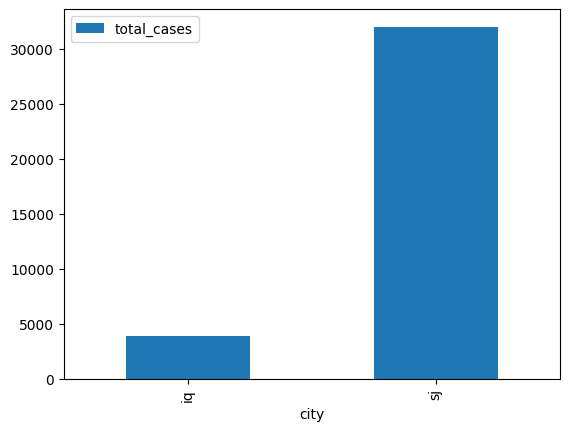

In [5]:
# Divido el dataset para cada ciudad

sj_df = train[train['city'] == 'sj']
iq_df = train[train['city'] == 'iq']

# Para tener una idea general vamos a visualizar los casos por ciudades
train[['city', 'total_cases']].groupby('city').sum().plot.bar()

```
Nuestra variable objetivo contiene muchos más casos para
San Juan en comparación con Iquitos, en parte se puede explicar
por la cantidad de habitantes. Sin embargo esta relación
se debe principalmente a el tiempo que se han recolectado
datos para cada ciudad.
```

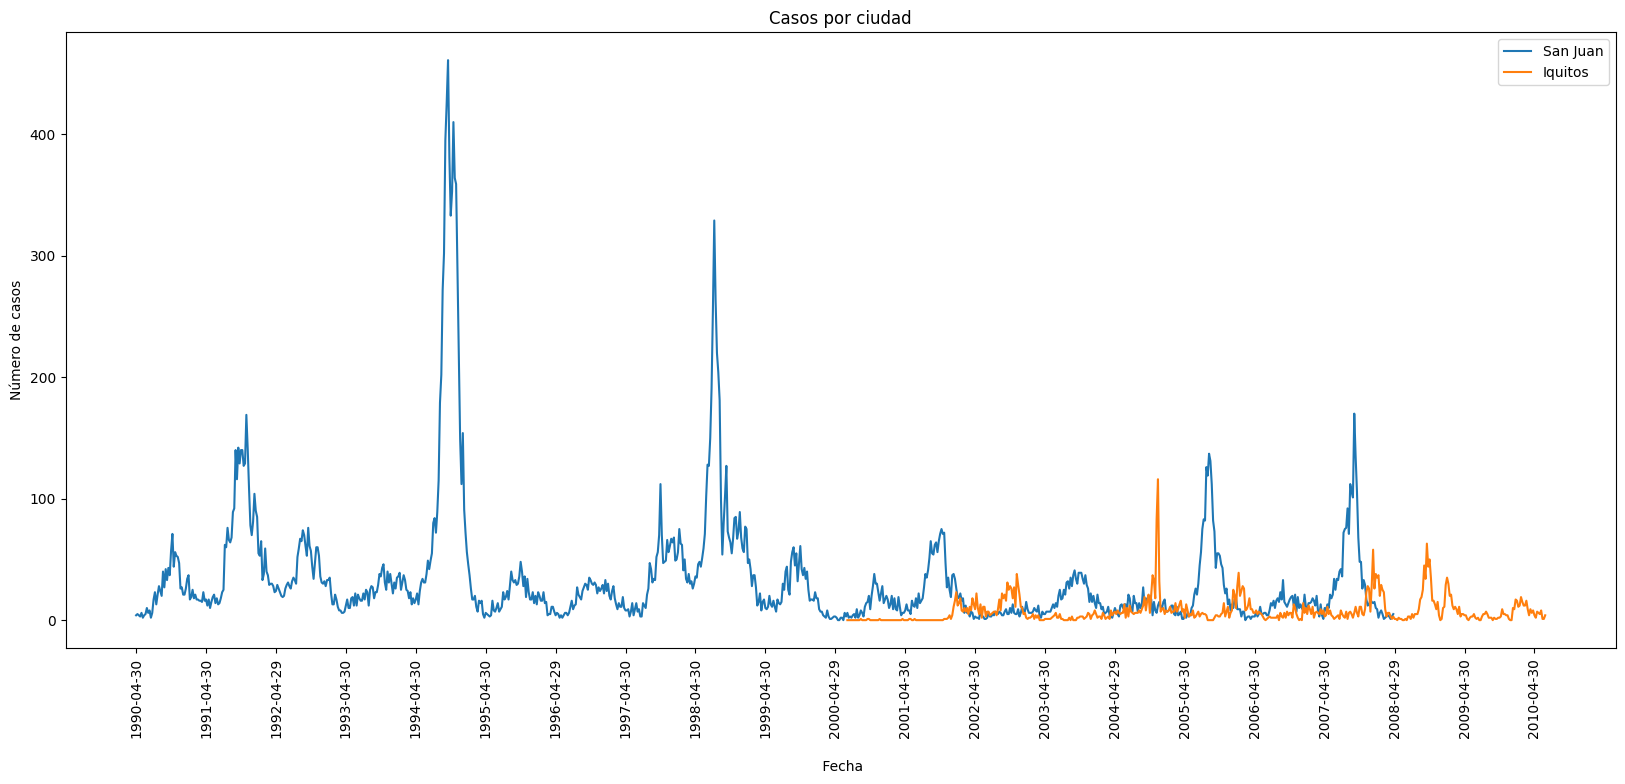

In [232]:
# pequeña funcion para calcular xticks cada año (52 semanas)
def generate_array(num_elements):
  return [i * 52 for i in range(num_elements)]

plt.figure(figsize=(20,8))
plt.xticks(rotation=90,ticks=generate_array(21))

# Grafica de la evolución de casos para cada ciudad.
ax = plt.subplot()
sns.lineplot(data = sj_df, x = 'week_start_date', y = 'total_cases', ax = ax, estimator=None)
sns.lineplot(data = iq_df, x = 'week_start_date', y = 'total_cases', ax = ax, estimator=None)
ax.set_title('Casos por ciudad')
ax.set_ylabel('Número de casos')
ax.set_xlabel('\n Fecha')
ax.legend(['San Juan', 'Iquitos'])

```
Aqui visualizamos que no solo es la cantidad de datos sino también
hay una mayor rendencia de casos en San Juan.

Es posible que exista temporalidad para los datos de San Juan.
```

### Tratamiento de datos faltantes

Al igual que en la primera actividad, los datos faltantes son interpolados linealmente consideranto las observaciones anteriores y futuras, visualizaremos este cambio con la variable que más datos perdidos tiene: `ndvi_ne`

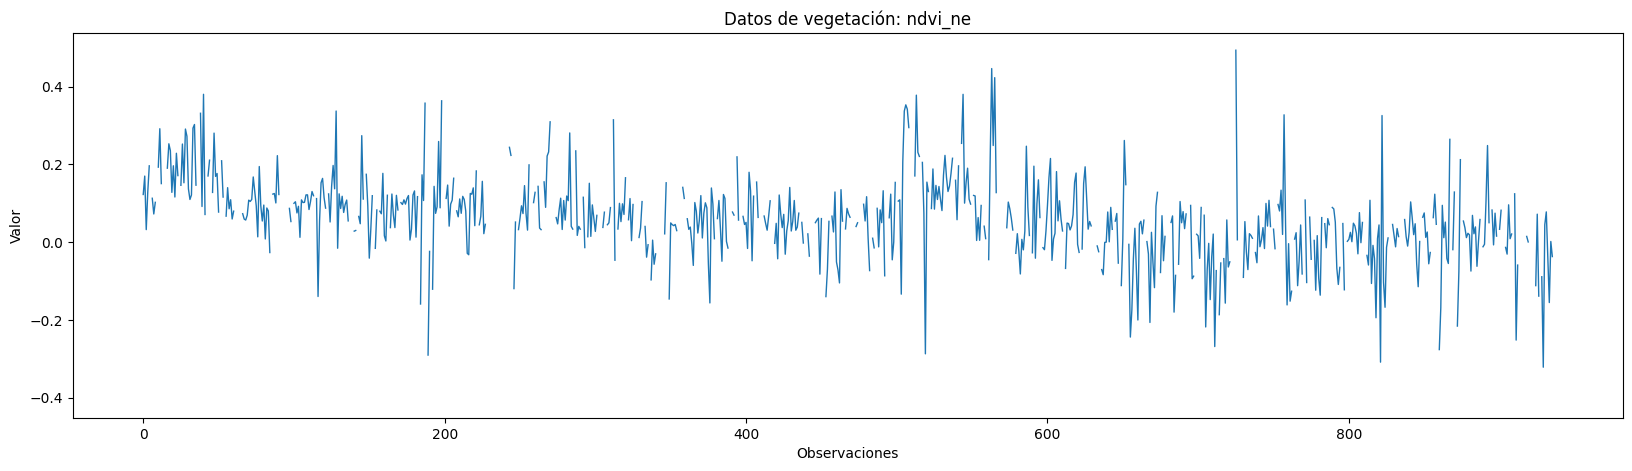

In [6]:
# Exploramos los datos faltantes en la variable que más faltantes tiene:

plt.figure(figsize = (20, 5))
(sj_df
     .ndvi_ne
     .plot
     .line(lw = 1))

plt.title('Datos de vegetación: ndvi_ne')
plt.xlabel('Observaciones')
plt.ylabel('Valor')
plt.show()

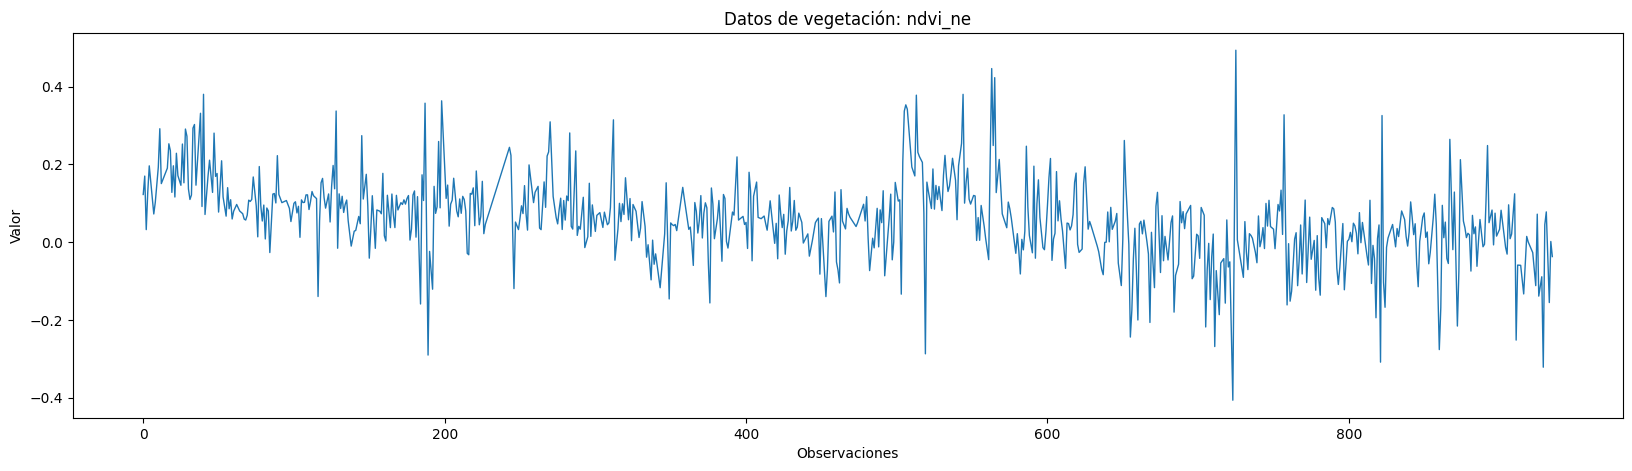

In [7]:
# Rellenamos los datos mediante una interpolación lineal

sj_df = sj_df.interpolate(method = 'linear')
iq_df = iq_df.interpolate(method = 'linear')

plt.figure(figsize = (20, 5))
(sj_df
     .ndvi_ne
     .plot
     .line(lw = 1))
plt.title('Datos de vegetación: ndvi_ne')
plt.xlabel('Observaciones')
plt.ylabel('Valor')
plt.show()

```
Considero que los variables faltantes han sido rellenados de
una manera aceptable.

Si bien esta tecnica mejor en datos cuyos faltantes sean más
esporadicos considero que es una técnica adecuada.
```

### Correlación entre variables

Realizaremos un análisis de correlación tomando especial énfasis en nuestra variable objetivo.

### Mapa de calor - todas las variables

Text(0.5, 1.0, 'Mapa de Correlacion arriba "San Juan" abajo "Iquitos"\n')

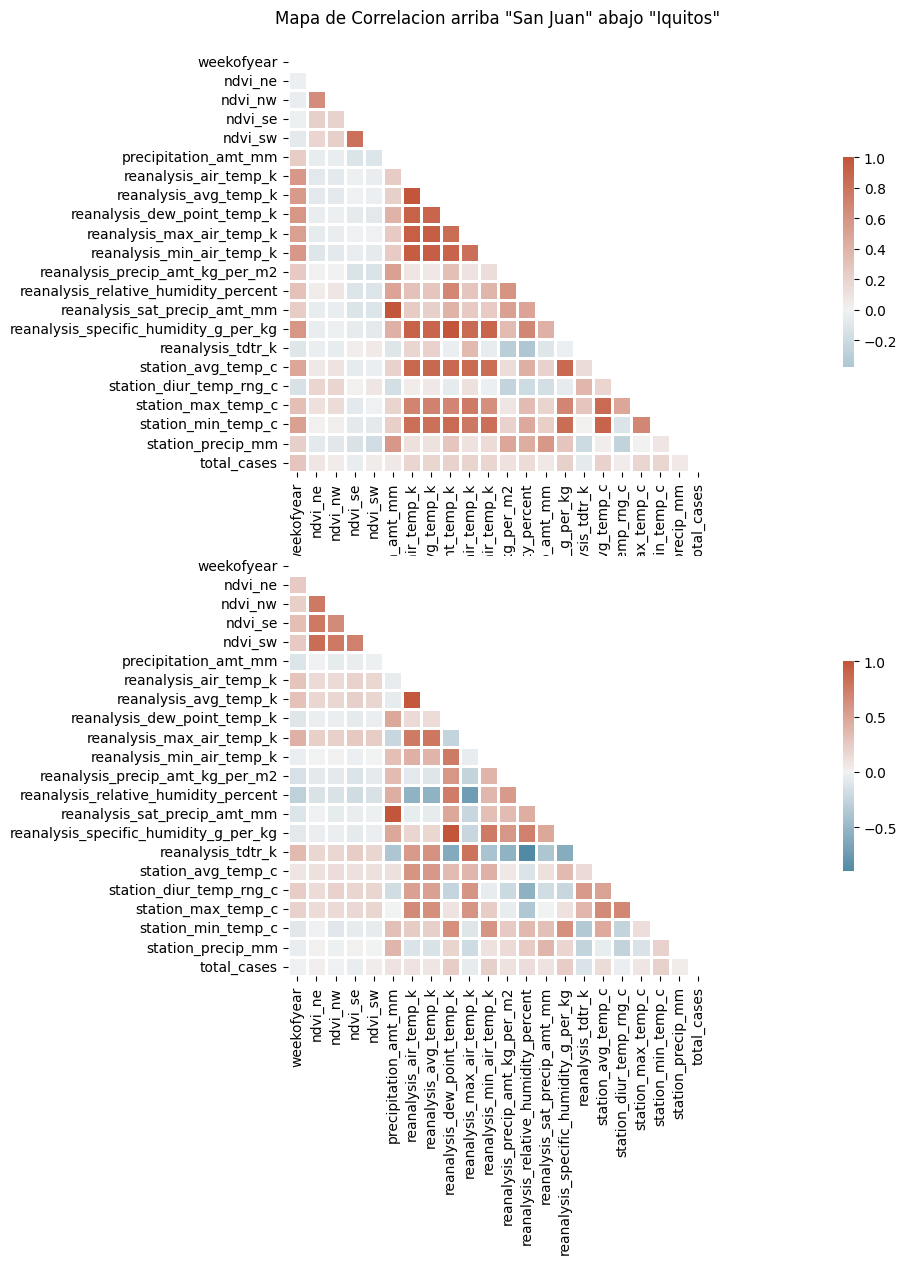

In [ ]:
# Calcular la matriz de correlación
corr_sj = sj_df.drop(['city','year','week_start_date'], axis=1).corr()
corr_iq = iq_df.drop(['city','year','week_start_date'], axis=1).corr()


# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr_sj, dtype=bool))

# Creamos los objetos subplot
fig, axs = plt.subplots( 2, 1, figsize = (35, 12))

# Mapeo de color
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Creo las dos gráficas

sns.heatmap(corr_sj, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": .5}, ax=axs[0])
sns.heatmap(corr_iq, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": .5}, ax=axs[1])

axs[0].set_title('Mapa de Correlacion arriba "San Juan" abajo "Iquitos"\n')


<Axes: >

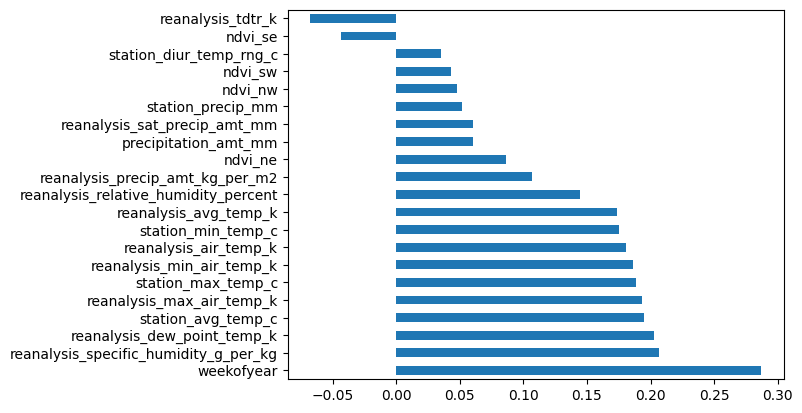

In [ ]:
# San Juan
(corr_sj
     .total_cases
     .drop('total_cases') # quitamos la variable objetivo
     .sort_values(ascending=False)
     .plot
     .barh())

<Axes: >

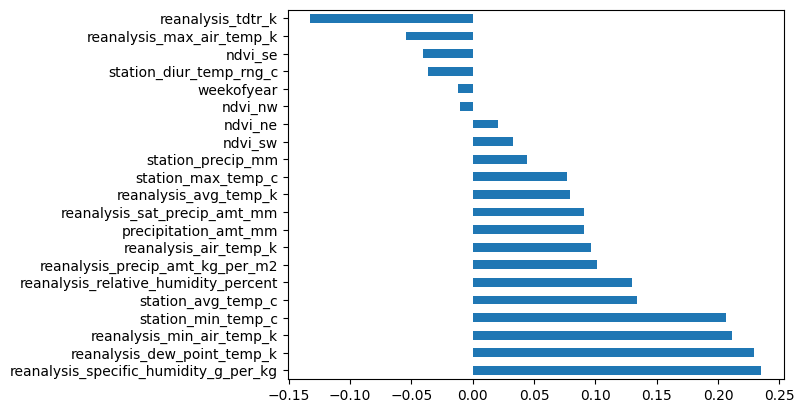

In [ ]:
# Iquitos
(corr_iq
     .total_cases
     .drop('total_cases') # quitamos la variable objetivo
     .sort_values(ascending=False)
     .plot
     .barh())

```
Algunas conlcuiones de la gráfica de correlación.

- Para cada ciudad existen variables diferentes:

- Para cada ciudad tomaremos las cuatro mejores correlaciones.
```
Vamos a calular nuestros modelos con las siguientes cuatro variables para cada ciudad:

**San Juan**

1. 'weekofyear',
2. 'reanalysis_specific_humidity_g_per_kg'
2. 'reanalysis_dew_point_temp_k',
2. 'station_avg_temp_c'

Interesante observar que la mayor correlación en la ciudad de San Juan es con la variable `weekofyear` lo cual nos da indicios de temporalidad en esta ciudad, esto no ocurre con Iquitos, por lo que dependiendo del modelo el generar uno para cada ciudad puede resultar beneficioso.

**Iquitos**

1. 'reanalysis_specific_humidity_g_per_kg',
2. 'reanalysis_dew_point_temp_k',
3. 'reanalysis_min_air_temp_k'
4. 'tation_avg_temp_c',

*Nota: de acuerdo al análisis de la Actividad 1: 'reanalysis_specific_humidity_g_per_kg' y 'reanalysis_dew_point_temp_k' tienen una alta correlación entre ellas, podemos considerar una variable adicional en nuestros modelos*


### Analisis de las variables escogidas

Vamos a analizar los valores de las variables escogidas

Text(0.5, 1.0, 'Mapa de correlacion Principales caracteristicas')

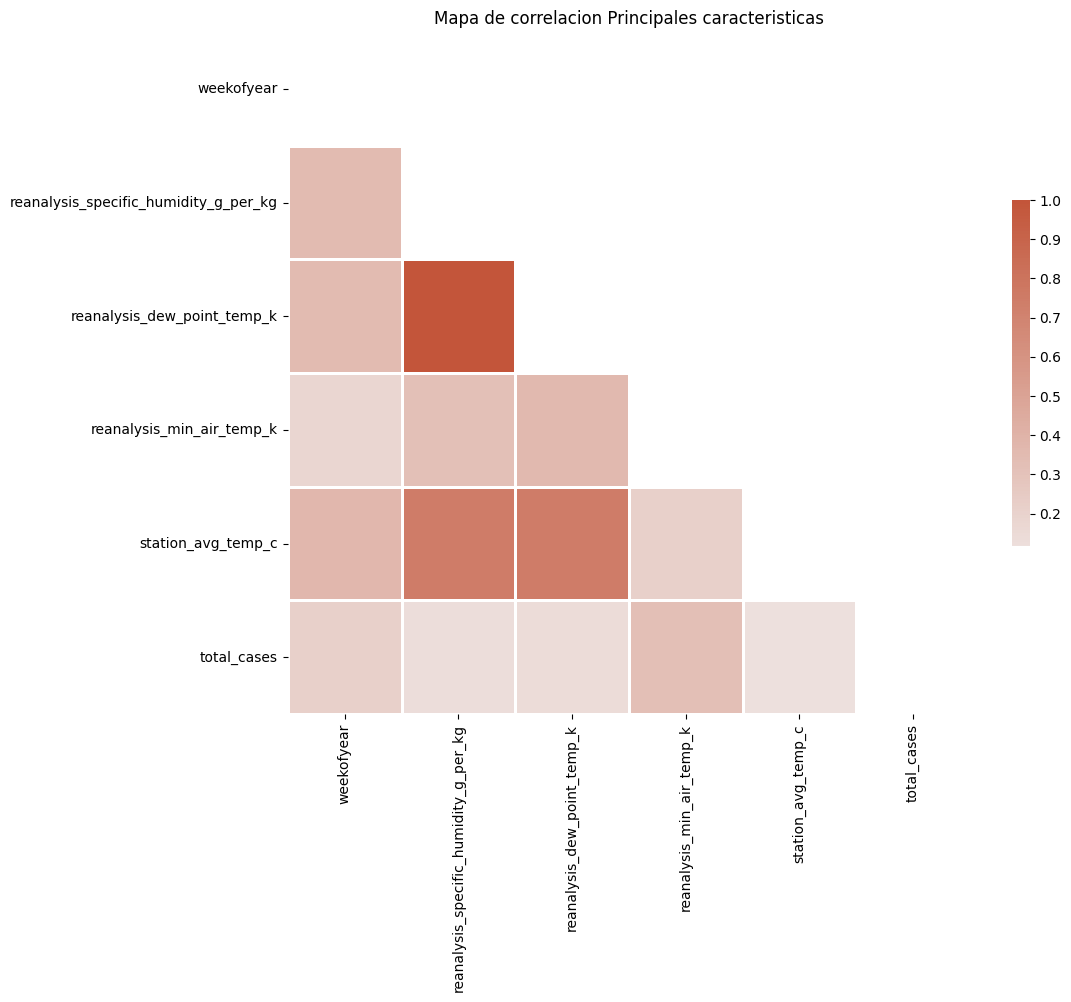

In [8]:
"""
   Creamos un mapa de correlacion con el las principales caracteristicas
"""
# Compute the correlation matrix
corr = train[['weekofyear',
              'reanalysis_specific_humidity_g_per_kg',
              'reanalysis_dew_point_temp_k',
              'reanalysis_min_air_temp_k',
              'station_avg_temp_c',
              'total_cases'
              ]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": .5}).set_title("Mapa de correlacion Principales caracteristicas")

```
Hay una elevada correlación entre dos de las variables, puede ser que estan midiendo lo mismo,
algo a considerar en nuestro modelo.
```

## Resumen de la reexploración

En esta sección elaboraré una función que recoga todas las transformaciones y las aplique al dataset, con la finalidad de acelerar el proceso de experimentación

In [9]:
"""
    Esta función recibe el dataset 'train' que puede ser el dataset de entrenamiento que incluye
    ya la variable objetivo 'total_cases' o también puede recibir el dataset de prueba 'test'
    y lo prepara ejecutando las mismas transformaciones para poder realizar predicciones.
"""
from sklearn.preprocessing import MinMaxScaler

def eda_pipeline( train, features_to_keep ):

    # Copia del dataset en las variables que interesan
    data = train[features_to_keep].copy()

    # Rellenar valores faltantes con interpolación lineal
    data = data.interpolate(method = 'linear')

    # Normalización de variables.
    scaler = MinMaxScaler()
    df_normal = scaler.fit_transform( data )

    # Vuelvo a colocar la columna 'total_cases' sin normalizar
    if 'total_cases' in train.columns:
        df_normal = np.append( df_normal, train['total_cases'].values.reshape(-1,1), axis=1 )

    return df_normal

In [10]:
"""
   Este será el Dataset utilizado en KNN-1
"""
# Caracteristicas de San Juan
features_sj = [ 'weekofyear',
                'reanalysis_specific_humidity_g_per_kg',
                'reanalysis_dew_point_temp_k',
                'station_avg_temp_c']

# Caracteristicas de Iquitos
features_iq = [ 'reanalysis_min_air_temp_k',
                'reanalysis_specific_humidity_g_per_kg',
                'reanalysis_dew_point_temp_k',
                'station_avg_temp_c']

# Divido el dataset para cada ciudad

sj_df = train[train['city'] == 'sj']
iq_df = train[train['city'] == 'iq']

sj_train = eda_pipeline(sj_df, features_sj)
iq_train = eda_pipeline(iq_df, features_iq)

sj_test = test[test['city'] == 'sj']
iq_test = test[test['city'] == 'iq']

sj_test = eda_pipeline(sj_test, features_sj)
iq_test = eda_pipeline(iq_test, features_iq)

In [11]:
# Nos muestra la cantidad de datos a predecir para cada ciudad.
# Hay una mayor representación de Iquitos que en los datos de entrenamiento.

[sj_test.shape,iq_test.shape]

[(260, 4), (156, 4)]

In [12]:
# Muestra de la primera fila Array para entrenar San Juan,
# al final la variable objetivo sin normalizar
sj_train[0]

array([0.32692308, 0.29739227, 0.33993342, 0.35968379, 4.        ])

In [13]:
# Muestra de la primera fila Array para Probar el modelo
# al final no existe la variable objetivo, la cual se debe calular
iq_test[0]

array([0.76530612, 0.66829149, 0.72153465, 0.60559006])

## Análisis de la variable objetivo

Hasta este momento hemos analizado los valores tal cual, sin embargo puede resultar beneficioso analizar la relación causa 👉 efecto.

El efecto de las mediciones realizadas pueden no ser inmediato, es decir la lluvia de un día puede tener un efecto porsterior en la población.

El mosquito necesita tiempo para su incubación en aguas reposadas, las cuales pueden provenir de la lluvia, por tanto analizaremos el dataset retrasando el efecto de la variable objetivo.


In [14]:
"""
   Este será el Dataset utilizado en Random Forest C
"""
# Volvemos a separar las features, de los labels.

# Divido el dataset para cada ciudad
sj_df_1week = train[train['city'] == 'sj'].drop('total_cases', axis = 1).copy()
iq_df_1week = train[train['city'] == 'iq'].drop('total_cases', axis = 1).copy()

label_sj = train[train['city'] == 'sj']['total_cases'].copy()
label_iq = train[train['city'] == 'iq']['total_cases'].copy()

# Elimino la primera observación de label y la última de train,
# de esta manera establezco que el total de casos se deben a lo
# ocurrido en la semana anterior
label_sj = label_sj.drop(label_sj.index[0])
label_iq = label_iq.drop(label_iq.index[0])

# Reseteo los indices de las etiquetas para que vuelva a iniciar en 0
label_sj.reset_index(drop = True, inplace = True)
label_iq.reset_index(drop = True, inplace = True)

# Eliminio la última observación de los features de cada ciudad
sj_df_1week = sj_df_1week.drop(sj_df_1week.index[-1])
iq_df_1week = iq_df_1week.drop(iq_df_1week.index[-1])

# Reseteo los indices de Iquitos para que inicien en 0 igual que su label
iq_df_1week.reset_index(drop = True, inplace = True)

# Vuelvo a unir el dataframe con la etiqueta ambas inician en cero sus indices
sj_df_1week = pd.concat([sj_df_1week, label_sj], axis = 1)
iq_df_1week = pd.concat([iq_df_1week, label_iq], axis = 1)

# Uno ambas ciudades en el mismo dataset
train_1week = pd.concat([sj_df_1week, iq_df_1week], axis = 0).reset_index(drop=True)

In [15]:
"""
   Este será el Dataset utilizado en SVR_A; SVR_B; Random Forest D
"""


# Volvemos atrás dos semanas

# Divido el dataset para cada ciudad
sj_df_2week = train[train['city'] == 'sj'].drop('total_cases', axis = 1).copy()
iq_df_2week = train[train['city'] == 'iq'].drop('total_cases', axis = 1).copy()

label_sj = train[train['city'] == 'sj']['total_cases'].copy()
label_iq = train[train['city'] == 'iq']['total_cases'].copy()

# Elimino la primera observación de label y la última de train,
# de esta manera establezco que el total de casos se deben a lo
# ocurrido en la semana anterior
label_sj = label_sj.iloc[2:]
label_iq = label_iq.iloc[2:]

# Reseteo los indices de las etiquetas para que vuelva a iniciar en 0
label_sj.reset_index(drop = True, inplace = True)
label_iq.reset_index(drop = True, inplace = True)

# Eliminio la última observación de los features de cada ciudad
sj_df_2week = sj_df_2week.iloc[:-2]
iq_df_2week = iq_df_2week.iloc[:-2]

# Reseteo los indices de Iquitos para que inicien en 0 igual que su label
iq_df_2week.reset_index(drop = True, inplace = True)

# Vuelvo a unir el dataframe con la etiqueta ambas inician en cero sus indices
sj_df_2week = pd.concat([sj_df_2week, label_sj], axis = 1)
iq_df_2week = pd.concat([iq_df_2week, label_iq], axis = 1)

# Uno ambas ciudades en el mismo dataset
train_2week = pd.concat([sj_df_2week, iq_df_2week], axis = 0).reset_index(drop=True)

In [18]:
train_2week[['city','year','weekofyear','precipitation_amt_mm','total_cases']].head()

,city,year,weekofyear,precipitation_amt_mm,total_cases
0,sj,1990,18,12.42,4
1,sj,1990,19,22.82,3
2,sj,1990,20,34.54,6
3,sj,1990,21,15.36,2
4,sj,1990,22,7.52,4


In [19]:
train_1week[['city','year','weekofyear','precipitation_amt_mm','total_cases']].head()

,city,year,weekofyear,precipitation_amt_mm,total_cases
0,sj,1990,18,12.42,5
1,sj,1990,19,22.82,4
2,sj,1990,20,34.54,3
3,sj,1990,21,15.36,6
4,sj,1990,22,7.52,2


```
Se han generado los siguientes nuevos datasets:

- train_1week, observaciones retrasadas una semana
- train_2week, observaciones retradadas dos semanas

A continuación analizaremos la correlación de estos nuevos dataset
```

<Axes: >

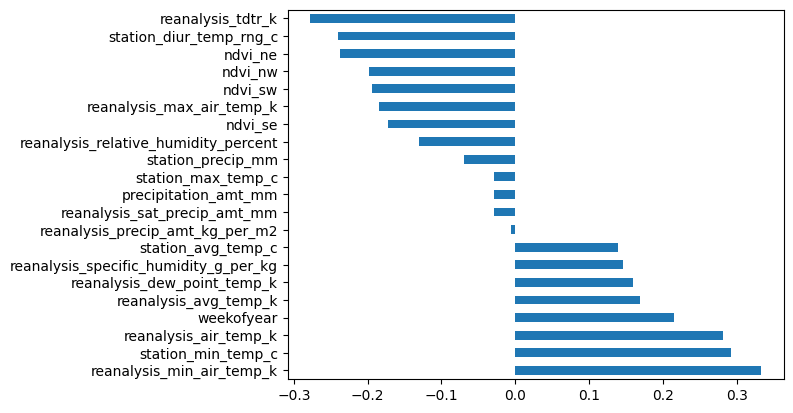

In [20]:
# Correlacion de variables (1 semana) en relacion con la variable objetivo.

corr = train_1week.drop(['city','year','week_start_date'], axis=1).corr()

(corr
     .total_cases
     .drop('total_cases') # quitamos la variable objetivo
     .sort_values(ascending=False)
     .plot
     .barh())

<Axes: >

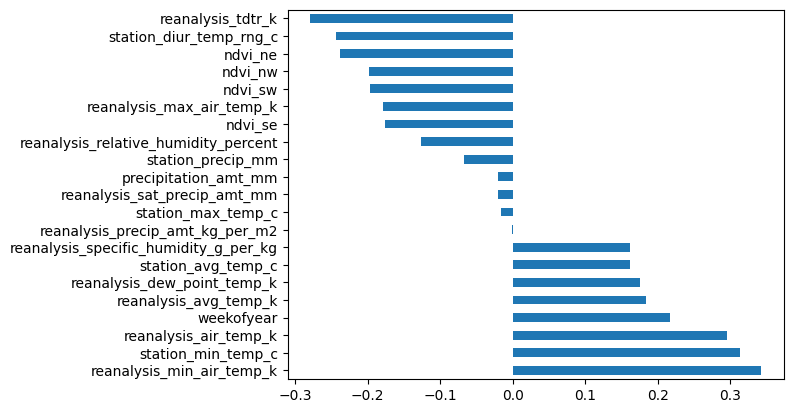

In [21]:
# Correlacion de variables (2 semana) en relacion con la variable objetivo.
corr = train_2week.drop(['city','year','week_start_date'], axis=1).corr()

(corr
     .total_cases
     .drop('total_cases') # quitamos la variable objetivo
     .sort_values(ascending=False)
     .plot
     .barh())

```
Se puede visualizar un incremento en la correlacion de las features con respecto a la
variable objetivo.

No hay mucha diferencia entre una semana y dos semanas de retraso, segunda semana ligeramente superior en correlación
```

Avanzaremos con el dataset retrasado en una semana.

Luego, para reducir la dimensionalidad de nuestro dataset y conla esperanza de caputurar de mejor manera la interaccion de variables similares realizaremos un análisis de PCA por grupos o bloques de medidas similares.

### PCA por grupos de variables

El primer paso será normalizar las variables.

Aplicaremos el PCA en los siguientes grupos de variables, la intención es agrupar variables que tienen una similar correlación con los casos totales, la intención es mantener y/o aumentar la correlación de estas variables respecto a los casos totales.

<br>

**Mantenemos** la variable de ciudad, permitir al Random Forest hacer la particion por ciudades.

<br>

**Grupo 1** (vegetacion)
- ndvi_se
- ndvi_sw
- ndvi_ne
- ndvi_nw

**Grupo 2** (correlacion negativa)
- reanalysis_tdtr_k
- station_diur_temp_rng_c
- reanalysis_max_air_temp_k
- reanalysis_relative_humidity_percent

**Grupo 3**
- reanalysis_specific_humidity_g_per_kg
- station_avg_temp_c
- reanalysis_dew_point_temp_k
- reanalysis_avg_temp_k

<br>

**Mantenemos** las tres variables mas fuertemente correlacionadas a la variable objetivo.
- reanalysis_air_temp_k
- station_min_temp_c
- reanalysis_min_air_temp_k

In [22]:
# Utilizaré la variable de ciudad en el Random Forest
# 1 -> San Juan
# 0 -> Iquitos

from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

train_1week['city'] = lb.fit_transform(train_1week['city'])

randomPCA_test = test.copy()
randomPCA_test['city'] = lb.fit_transform(randomPCA_test['city'])


In [23]:
# Caracteristicas para el random forest con PCA

features_PCA = ['city',
                'ndvi_se',
                'ndvi_sw',
                'ndvi_ne',
                'ndvi_nw',

                'reanalysis_tdtr_k',
                'station_diur_temp_rng_c',
                'reanalysis_max_air_temp_k',
                'reanalysis_relative_humidity_percent',

                'reanalysis_specific_humidity_g_per_kg',
                'station_avg_temp_c',
                'reanalysis_dew_point_temp_k',
                'reanalysis_avg_temp_k',

                'reanalysis_air_temp_k',
                'station_min_temp_c',
                'reanalysis_min_air_temp_k']

train_PCA = eda_pipeline(train_1week, features_PCA)
test_PCA  = eda_pipeline(randomPCA_test, features_PCA)

# Volver a comvertir de ndarray a Dataframe

test_PCA = pd.DataFrame( test_PCA, columns = features_PCA )
features_PCA.append('total_cases')
train_PCA = pd.DataFrame( train_PCA, columns = features_PCA )


In [24]:
## Aplicamos el PCA por partes

from sklearn.decomposition import PCA

pca = PCA( n_components = 1 ) # Comprimir a una columna

vegetacion_PCA = train_PCA[['ndvi_se','ndvi_sw','ndvi_ne','ndvi_nw']].copy()
pca.fit(vegetacion_PCA)
train_PCA.insert(1,'vegetacion', pca.transform(vegetacion_PCA))

grupo2_PCA = train_PCA[['reanalysis_tdtr_k','station_diur_temp_rng_c','reanalysis_max_air_temp_k','reanalysis_relative_humidity_percent']].copy()
pca.fit(grupo2_PCA)
train_PCA.insert(2,'grupo2', pca.transform(grupo2_PCA))

grupo3_PCA = train_PCA[['reanalysis_specific_humidity_g_per_kg','station_avg_temp_c','reanalysis_dew_point_temp_k','reanalysis_avg_temp_k']].copy()
pca.fit(grupo3_PCA)
train_PCA.insert(3,'grupo3', pca.transform(grupo3_PCA))

train_PCA = train_PCA.drop(['ndvi_se',
                'ndvi_sw',
                'ndvi_ne',
                'ndvi_nw',

                'reanalysis_tdtr_k',
                'station_diur_temp_rng_c',
                'reanalysis_max_air_temp_k',
                'reanalysis_relative_humidity_percent',

                'reanalysis_specific_humidity_g_per_kg',
                'station_avg_temp_c',
                'reanalysis_dew_point_temp_k',
                'reanalysis_avg_temp_k' ] ,axis = 1)

train_PCA.head()



,city,vegetacion,grupo2,grupo3,reanalysis_air_temp_k,station_min_temp_c,reanalysis_min_air_temp_k,total_cases
0,1.0,-0.041977,-0.322475,0.516138,0.388291,0.486239,0.692308,5.0
1,1.0,-0.041454,-0.297265,0.235465,0.472710,0.688073,0.730769,4.0
2,1.0,-0.100937,-0.280949,0.018847,0.548064,0.743119,0.800000,3.0
3,1.0,0.107476,-0.243608,-0.012197,0.575260,0.788991,0.776923,6.0
4,1.0,0.186673,-0.088072,-0.166647,0.645515,0.844037,0.815385,2.0


<Axes: >

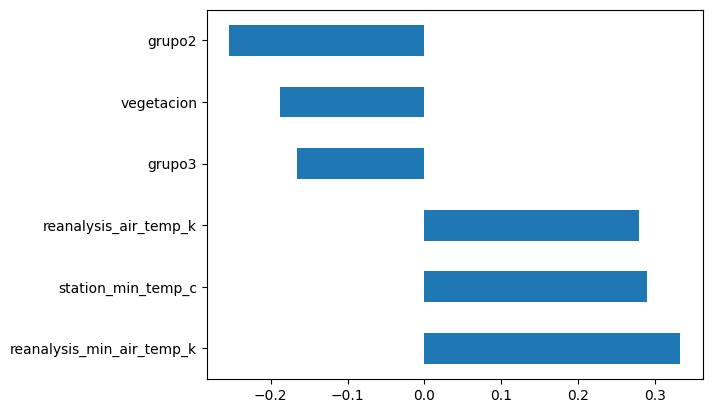

In [25]:
# Correlacion de variables PCA en relacion con la objetivo. (retrasado 1 semana)
corr = train_PCA.drop(['city'], axis=1).corr()

(corr
     .total_cases
     .drop('total_cases') # quitamos la variable objetivo
     .sort_values(ascending=False)
     .plot
     .barh())

```
Hemos logrado mantener los niveles de correlacion en los grupos
 generados mediante PCA y hemos simplificado nuestro dataset.
```

Apliacaremos los mismos pasos para el Dataset TEST.

In [26]:
# Tratamiento del dataset de prueba.

pca = PCA( n_components = 1 ) # Comprimir a una columna

vegetacion_PCA = test_PCA[['ndvi_se','ndvi_sw','ndvi_ne','ndvi_nw']].copy()
pca.fit(vegetacion_PCA)
test_PCA.insert(1,'vegetacion', pca.transform(vegetacion_PCA))

grupo2_PCA = test_PCA[['reanalysis_tdtr_k','station_diur_temp_rng_c','reanalysis_max_air_temp_k','reanalysis_relative_humidity_percent']].copy()
pca.fit(grupo2_PCA)
test_PCA.insert(2,'grupo2', pca.transform(grupo2_PCA))

grupo3_PCA = test_PCA[['reanalysis_specific_humidity_g_per_kg','station_avg_temp_c','reanalysis_dew_point_temp_k','reanalysis_avg_temp_k']].copy()
pca.fit(grupo3_PCA)
test_PCA.insert(3,'grupo3', pca.transform(grupo3_PCA))

test_PCA = test_PCA.drop(['ndvi_se',
                'ndvi_sw',
                'ndvi_ne',
                'ndvi_nw',

                'reanalysis_tdtr_k',
                'station_diur_temp_rng_c',
                'reanalysis_max_air_temp_k',
                'reanalysis_relative_humidity_percent',

                'reanalysis_specific_humidity_g_per_kg',
                'station_avg_temp_c',
                'reanalysis_dew_point_temp_k',
                'reanalysis_avg_temp_k' ] ,axis = 1)

test_PCA.head()

,city,vegetacion,grupo2,grupo3,reanalysis_air_temp_k,station_min_temp_c,reanalysis_min_air_temp_k
0,1.0,-0.373818,-0.245322,0.252074,0.533578,0.600,0.755556
1,1.0,-0.411473,-0.360924,0.308635,0.531256,0.640,0.777778
2,1.0,-0.308731,-0.120814,-0.016752,0.664022,0.688,0.755556
3,1.0,-0.293297,-0.233896,0.104788,0.695762,0.816,0.792593
4,1.0,-0.363741,-0.240666,0.083214,0.707954,0.728,0.822222


Estos nuevos datasets se reutilizaran en Random-Forest-C



### Dataset 2 semanas atrás

Con la finalidad de mejorar las predicciones realizaremos un nuevo experimento.

- Tomaremos los datos retrasados en dos semanas.
- Seleccionaremos las variables con mayor correlación hacia la variable objetivo.

In [27]:
# Utilizaré la variable de ciudad en el Random Forest
# 1 -> San Juan
# 0 -> Iquitos

from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

train_2week['city'] = lb.fit_transform(train_2week['city'])

test_2week = test.copy()
test_2week['city'] = lb.fit_transform(test_2week['city'])


In [28]:
"""   DataFrame 2 SEMANAS ATRAS

  Luego deberemos adelantar los resultados de la predicción en dos semanas
  Partimos de los dataset retrasados en dos semanas aplicando EDA
  En este caso ** NO APLICAREMOS_ PCA** solamente mantendremos las features
  con mayor correlación con la variable objetivo.
"""

# Features con mejores correlaciones con retraso de dos semanas.

features_2week=['city',
                'reanalysis_tdtr_k',
                'station_diur_temp_rng_c',
                'ndvi_ne',
                'ndvi_nw',
                'ndvi_sw',
                'reanalysis_max_air_temp_k',
                'reanalysis_avg_temp_k',
                'reanalysis_air_temp_k',
                'station_min_temp_c',
                'reanalysis_min_air_temp_k',
                ]

test_2week  = eda_pipeline(test_2week, features_2week)
train_2week = eda_pipeline(train_2week, features_2week)

test_2week = pd.DataFrame( test_2week, columns = features_2week )
features_2week.append('total_cases')
train_2week = pd.DataFrame( train_2week, columns = features_2week )


<Axes: >

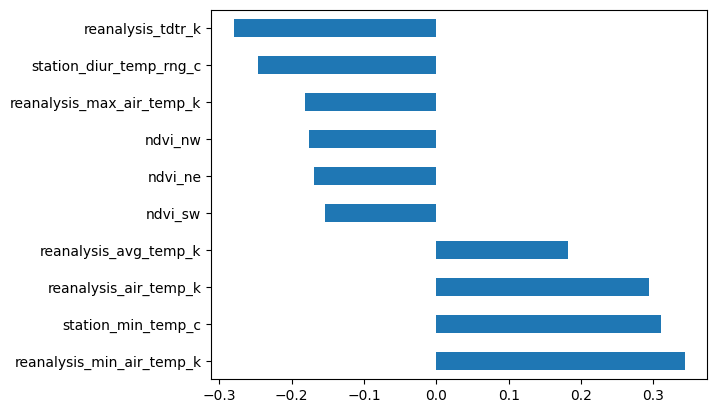

In [29]:
# Correlacion de variables PCA en relacion con la objetivo.
corr = train_2week.drop(['city'], axis = 1).corr()

(corr
     .total_cases
     .drop('total_cases') # quitamos la variable objetivo
     .sort_values(ascending=False)
     .plot
     .barh())

### Analisis de los casos positivos para cada ciudad

Visualizaremos granularmente la distribución de casos para cada ciudad.

Cantidad única de casos en San Juan: 134
Cantidad unica de casos en Iquitos: 46


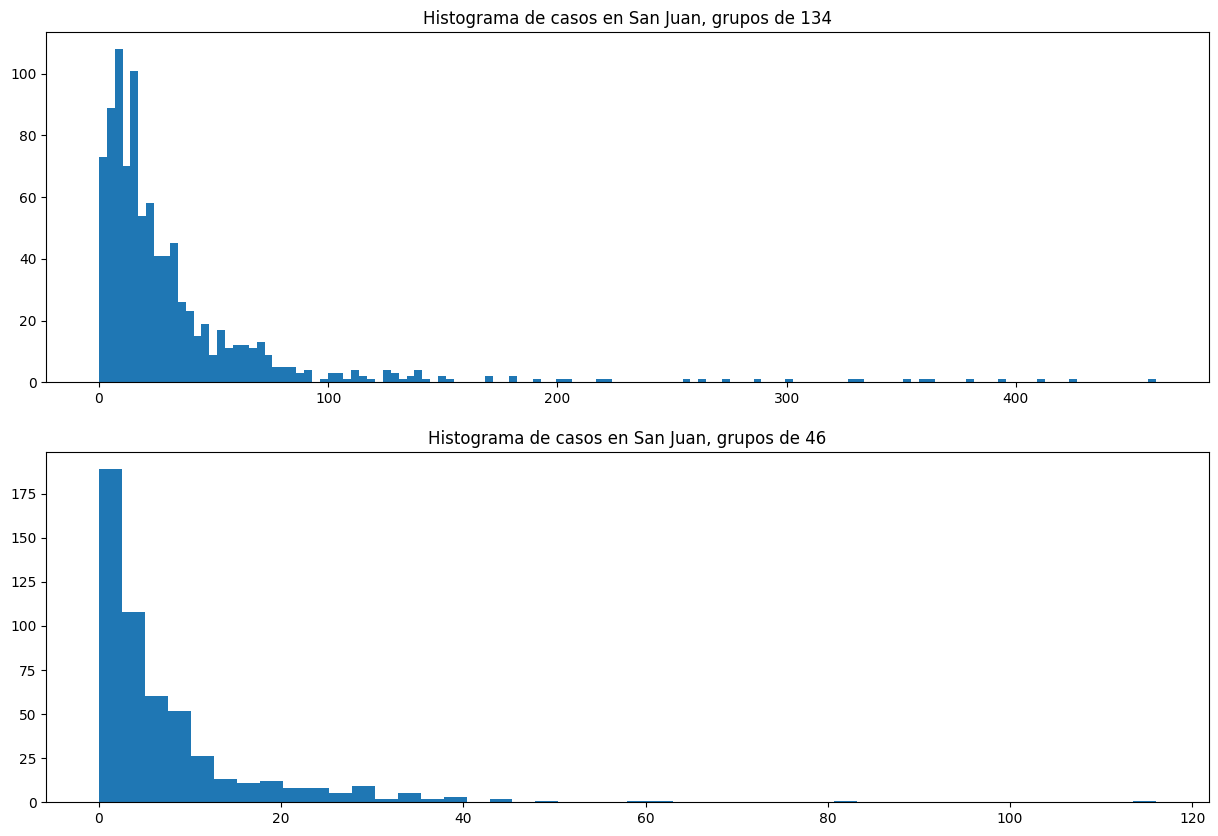

In [31]:
plt.figure(figsize = (15, 10))

plt.subplot(2, 1, 1)
plt.hist(sj_df['total_cases'], bins = 134)
plt.title('Histograma de casos en San Juan, grupos de 134')

print( "Cantidad única de casos en San Juan: {}".format( sj_df['total_cases'].nunique() ))

plt.subplot(2, 1, 2)
plt.hist(iq_df['total_cases'], bins = 46)
plt.title('Histograma de casos en San Juan, grupos de 46')

print( "Cantidad unica de casos en Iquitos: {}".format( iq_df['total_cases'].nunique() ))



plt.show()

Exploramos la posibilidad de disminuir la varidedad de resultados únicos para San Juan, es decir, reducir la dimensionalidad

Esto puede resultar beneficioso para los algoritmos principalmente de clasificación, tipo KNN o SVM

El siguiente código divide la columna objetivo de la misma manera que como se calcula el histograma, y asigna un nuevo valor que es la moda, el valor más repetido en su categoria.

In [35]:
# Este código fue generado casi por completo por GeminiAI (tras varios intentos)

train_bin = train.copy()

# Bin the column without labels first
train_bin['binned_column'] = pd.cut(train_bin['total_cases'], bins=46)

# Group by the bins and find the most common value in each
bin_labels = (train_bin
              .groupby('binned_column')['total_cases']
              .apply(lambda x: x.mode()[0] if not x.empty else None)
              )

# Map the bin intervals to the mode values
train_bin['binned_column'] = train_bin['binned_column'].map(bin_labels)

train_bin[['total_cases','binned_column']].sample(100)

,total_cases,binned_column
574,8,0.0
948,0,0.0
48,16,11.0
129,61,68.0
61,13,11.0
...,...,...
754,20,11.0
251,17,11.0
960,1,0.0
879,8,0.0


```
Si bien al Algortimo funciona no estoy convencido por el resultado.

Para valores bajos se pierde la resolución, no es el efecto deseado
```

In [36]:
# la idea es que para numeros pequeños mantener los valores, pero agrupar los numeros grandes de tal
# manera que tengamos menos valores únicos....
# A continuación visualizamos el total de casos únicos.
bins_special = np.sort(train['total_cases'].unique())
bins_special

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        80,  81,  82,  83,  84,  85,  89,  90,  91,  92,  99, 101, 102,
       104, 106, 108, 112, 115, 116, 119, 126, 127, 128, 129, 131, 135,
       137, 140, 141, 142, 149, 150, 154, 169, 170, 179, 181, 191, 202,
       204, 220, 221, 256, 263, 272, 288, 302, 329, 333, 353, 359, 364,
       381, 395, 410, 426, 461])

Como conclusión es que, para que esto funcione debemos definir fronteras personalizadas, que permita mantener la granularidad en los valores pequeños y agrupar los valores más elevados:

`|0|1|2|3|.....|20|22|25|30|40|50|60|80|120|240|inf|`

Esto agrupará los esporádicos casos elevados, aumentando además la probabilidad de que sean escogidos por nuestro modelo.

Esta es una posible mejora para los algoritmos como KNN y SVM, de tener tiempo se explorará esta posibilidad.

---
# Predicción
---

## KNN-1

El primer intento que se utilizará sera la predicción mediante "Nearest Neighbors".

La idea es establecer una métrica base propia e ir mejorando.

Datos importantes a tomar en cuenta:

- Se ha dividido el dataset y entrenado independientemente para cada ciudad.
- Tomamos las cuatro mejores variables que tienen la mayor correlación con nuestra variable objetivo
- Estas variables son diferentes para cada ciudad.
- Para San Juan hemos incluido la variable `weekofyear` que norlmalmente se eliminaba.

Tomamos como punto de partida el notebook visto en clase `"1 - KNN - Regresión"` ajustandolo a nuestro dataset el cual es de tipo `ndarray`



In [37]:
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

cv = KFold( n_splits = 5, shuffle = True, random_state = seed )

Max Value uniform : 0.04485720787347821 (19)
Max Value distance : 0.03419615428376379 (13)


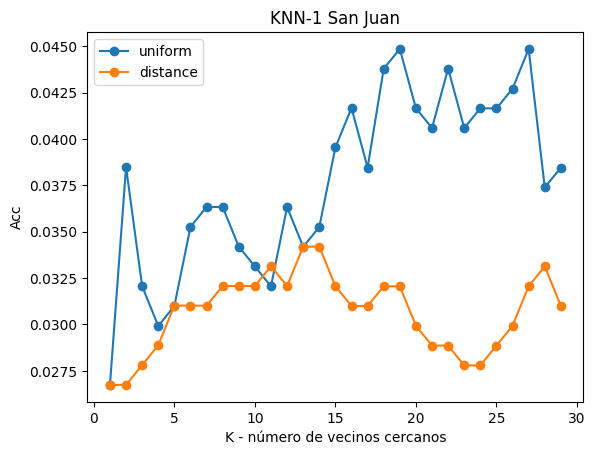

In [40]:
# KNN -  San Juan

for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsClassifier(n_neighbors, weights = weights)
       for train_fold, test_fold in cv.split(sj_train):
          # División train test aleatoria
          f_train = sj_train[train_fold]
          f_test  = sj_train[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train[:, :-1], y = f_train[:, -1])
          y_pred = knn.predict(X = f_test[:, :-1])
          # evaluación del modelo
          acc = accuracy_score(f_test[:, -1], y_pred)
          fold_accuracy.append(acc)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

   plt.plot(range(1,len(total_scores)+1), total_scores,
             marker='o', label=weights)
   print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
   plt.ylabel('Acc')


plt.legend()
plt.xlabel('K - número de vecinos cercanos')
plt.title('KNN-1 San Juan')
plt.show()



```
Existe una marcada diferencia entre los tipos 'uniform' y 'distance'

Claramente nuestros mejores Hiperparametros son: 'uniform' : '19' vecinos

La precisión de la métrica predicciónes es extremadamente baja: 4.4%

```
La diferencia enntre el tipo 'uniform' y 'distance' probablemente se debe a la correlación entre variables.

Para San Juan
 -  'weekofyear',
 -  'reanalysis_specific_humidity_g_per_kg',
 -  'reanalysis_dew_point_temp_k',
 -  'station_avg_temp_c'

Tres de las variables estan altamente relacionadas entre si.

> **Nuestro bajo valor de predicción es un indicativo de que las variables escogidas y/o el tratamiento previo de los datos no ha sido el adecuado.**


Max Value uniform : 0.18269230769230768 (24)
Max Value distance : 0.15961538461538463 (28)


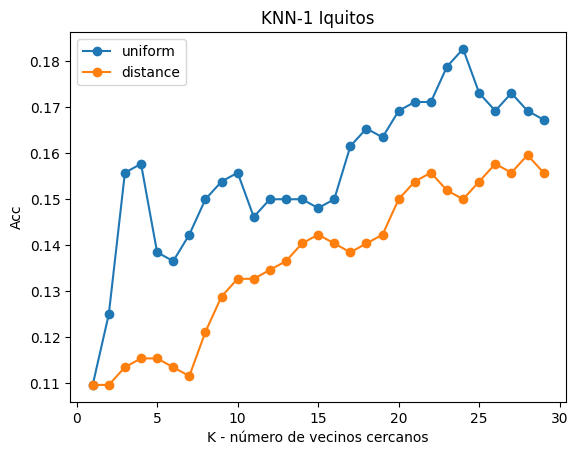

In [41]:
# KNN - Iquitos

for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsClassifier(n_neighbors, weights = weights)
       for train_fold, test_fold in cv.split(iq_train):
          # División train test aleatoria
          f_train = iq_train[train_fold]
          f_test  = iq_train[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train[:, :-1], y = f_train[:, -1])
          y_pred = knn.predict(X = f_test[:, :-1])
          # evaluación del modelo
          acc = accuracy_score(f_test[:, -1], y_pred)
          fold_accuracy.append(acc)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

   plt.plot(range(1,len(total_scores)+1), total_scores,
             marker='o', label=weights)
   print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
   plt.ylabel('Acc')


plt.legend()
plt.xlabel('K - número de vecinos cercanos')
plt.title('KNN-1 Iquitos')
plt.show()


```
Hay una mejora muy significativa en cuanto a la presición: 18.2%

Si bien el hiperparámetro 'uniform' es superior, no observamos un
decaimiento a medida que se aumentan los vecinos como ocurrió con
San Juan

```
Caracteristicas de Iquitos

- 'reanalysis_min_air_temp_k',
- 'reanalysis_specific_humidity_g_per_kg',
- 'reanalysis_dew_point_temp_k',
- 'station_avg_temp_c'

**Posibles causas:**
- Las caracteristicas y/o mediciones de ambas ciudades son distintos
- La correlación entre las variables es muy alta (miden lo mismo)
- No es el algoritmo indicado para el conjunto de datos.



## KNN-2

Vamos a realizar el mismo algoritmo pero esta vez variando un poco las variables.

##### **Nuestra hipotesis es que la alta correlación entre variables escogidas establece un techo para el algortimo.**

Introduciremos las variables:

- 'reanalysis_precip_amt_kg_per_m2'

> TLDR: No obtenemos mejores resultados que con KNN-1

In [42]:
# Divido el dataset para cada ciudad

# Caracteristicas de San Juan
features_sj = [ 'weekofyear',
                'reanalysis_specific_humidity_g_per_kg',
                'reanalysis_precip_amt_kg_per_m2',
                'station_avg_temp_c']

# Caracteristicas de Iquitos
features_iq = [ 'reanalysis_min_air_temp_k',
                'reanalysis_specific_humidity_g_per_kg',
                'reanalysis_precip_amt_kg_per_m2',
                'station_avg_temp_c']

sj_df = train[train['city'] == 'sj']
iq_df = train[train['city'] == 'iq']

sj_train = eda_pipeline(sj_df, features_sj)
iq_train = eda_pipeline(iq_df, features_iq)

sj_test = test[test['city'] == 'sj']
iq_test = test[test['city'] == 'iq']

sj_test = eda_pipeline(sj_test, features_sj)
iq_test = eda_pipeline(iq_test, features_iq)

Max Value uniform : 0.044868585732165206 (29)
Max Value distance : 0.039549436795995 (27)


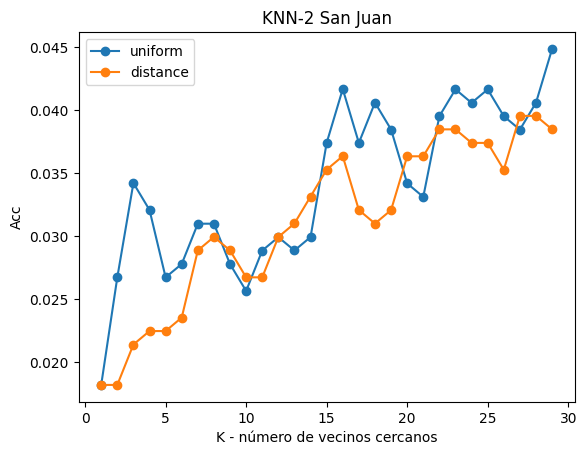

In [43]:
# KNN -  San Juan

for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsClassifier(n_neighbors, weights = weights)
       for train_fold, test_fold in cv.split(sj_train):
          # División train test aleatoria
          f_train = sj_train[train_fold]
          f_test  = sj_train[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train[:, :-1], y = f_train[:, -1])
          y_pred = knn.predict(X = f_test[:, :-1])
          # evaluación del modelo
          acc = accuracy_score(f_test[:, -1], y_pred)
          fold_accuracy.append(acc)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

   plt.plot(range(1,len(total_scores)+1), total_scores,
             marker='o', label=weights)
   print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
   plt.ylabel('Acc')


plt.legend()
plt.xlabel('K - número de vecinos cercanos')
plt.title('KNN-2 San Juan')
plt.show()

```
Interesante notar como con el cambio de una variable mejora notablemente
el desempeño del hiperparámetro 'distance'
```

Max Value uniform : 0.18076923076923077 (18)
Max Value distance : 0.17115384615384616 (26)


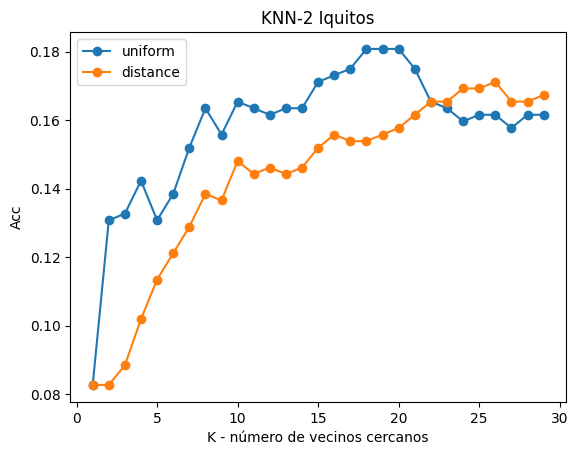

In [44]:
# KNN - Iquitos

for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsClassifier(n_neighbors, weights = weights)
       for train_fold, test_fold in cv.split(iq_train):
          # División train test aleatoria
          f_train = iq_train[train_fold]
          f_test  = iq_train[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train[:, :-1], y = f_train[:, -1])
          y_pred = knn.predict(X = f_test[:, :-1])
          # evaluación del modelo
          acc = accuracy_score(f_test[:, -1], y_pred)
          fold_accuracy.append(acc)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

   plt.plot(range(1,len(total_scores)+1), total_scores,
             marker='o', label=weights)
   print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
   plt.ylabel('Acc')


plt.legend()
plt.xlabel('K - número de vecinos cercanos')
plt.title('KNN-2 Iquitos')
plt.show()

```
Para Iquitos algo notable es que con el cambio de una variable el "ascenso"
de la preción se produce con menos vecinos.
```

Es un nueva indicación de que las variables a escoger y su tratamiento son muy importantes, (quizá más importates que los hiperparámetros)

A continuación exploraremos otros algoritmos en búsqueda de mejores resultados.

--------------------------

## RandomForest-A

Conociendo las limitacionde de los "Árboles de decisión" vamos a realizar un intento directamente pasando a 'Random Forest' realizaré un primer modelo más sencillo explorando algunos parámetros, luego utilizaremos GridSearch ayudanonos a explorar más profundamente las posibilidades de hiperparámetros.

Primer acercamiento, mas "sencillo" sin `Cross Validation` para probar las aguas.


### Dataset para Random Forest

En nuestro primer intento de KNN dividimos el dataset y los experimentos para cada ciudad.

En el caso de RandomForest **tomaremos todo el dataset**, e incluiremos la variable 'city' binarizada, de esta manera el algoritmo se encargara de tomar la desición de predicción para una ciudad u otra.

Para ello preparamos un nuevo dataset que se utilizará en Random Forest.

In [45]:
# Utilizaré la variable de ciudad en el Random Forest
# 1 -> San Juan
# 0 -> Iquitos

from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

randomF_df = train.copy()
randomF_df['city'] = lb.fit_transform(randomF_df['city'])

randomF_test = test.copy()
randomF_test['city'] = lb.fit_transform(randomF_test['city'])


# Caracteristicas para el random forest


features_rf = [ 'city',
                'reanalysis_min_air_temp_k',
                'reanalysis_specific_humidity_g_per_kg',
                'reanalysis_dew_point_temp_k',
                'station_avg_temp_c']

randomF_train = eda_pipeline(randomF_df, features_rf)
randomF_test = eda_pipeline(randomF_test, features_rf)

# Volver a convertir de ndarray a Dataframe

random_test_df = pd.DataFrame( randomF_test, columns = features_rf )
features_rf.append('total_cases')
random_train_df = pd.DataFrame( randomF_train, columns = features_rf )


Al utilizar nuestra función `eda_pipeline()` nuestros valores serán normalizados, sin embargo, investigando un poco esto no debería afectar negativamente al algoritmo de random forest.

In [46]:
random_train_df.head() # dataset normalizado, no hay alteracion en 'city' ni en 'total_cases'

,city,reanalysis_min_air_temp_k,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,total_cases
0,1.0,0.692308,0.262659,0.314680,0.430091,4.0
1,1.0,0.730769,0.418164,0.489213,0.565350,5.0
2,1.0,0.800000,0.586900,0.657583,0.565350,4.0
3,1.0,0.776923,0.566808,0.643471,0.645897,3.0
4,1.0,0.815385,0.628226,0.701541,0.802432,6.0


In [47]:
# Dividimos en train test el dataset
X = random_train_df.iloc[:, :-1]
y = random_train_df.iloc[:, -1]

In [48]:
# En este primer intento vamos con Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

In [49]:
# Para nuestro primer acercamiento exploraremos solamente un hiperparámetro: n_estimators
# Vamos a ir re-ejecutando este cóidgo y los resultados obtenidos se resumiran en una tabla

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 23, random_state = seed)
regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=23, random_state=42)

In [54]:
y_pred = regressor.predict(X_test)

"""
   Nuestro mejor parametro es n_estimators = 23
   Con esto vamos a predecir nuestro dataframe _test_
   Subiremos estos valores al csv para poder comprarlos
   con KNN y evaluar el mejor modelo.
"""
randomF_A_prediction = regressor.predict(random_test_df)

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae_rfA = mean_absolute_error(y_test, y_pred)
mse_rfA = mean_squared_error(y_test, y_pred)
r2_rfA = r2_score(y_test, y_pred)

print("MAE: ", mae_rfA)
print("MSE: ", mse_rfA)
print("R2: ", r2_rfA)

MAE:  24.134157236450267
MSE:  2792.6775060206646
R2:  0.13003974332875579


### Resultados Random Forest A - búsqueda "manual"

| n_estimators |    MAE    |   MSE  |   R2   |
|--------------|-----------|--------|--------|
| 10 | 24.50 | 2852 | 0.11   |
| **23** | **24.13** | **2792** | **0.130**  |
| 25 | 24.26 | 2810 | 0.124  |
| 28 | 24.24 | 2811 | 0.124  |
| 50 | 24.54 | 2843 | 0.11   |
| 75 | 24.26 | 2809 | 0.124  |
| 100| 24.36 | 2833 | 0.117 |

De la tabla podemos concluir que nuestro Hiper-parámetro n_estimators  ideal esta alrededor de los 25, más estimadores no mejoran significativamente los resultados

<br>

**Conclusiones del primer Random Forest**

El valor de la métrica MAE en primera instancia es prometedor, sin embargo, el valor de error cuadradro (r2) es muy bajo.

**Hipótesis:** Es necesario explorar el espacio de Hiperparámetros y Cross Validation para mejorar los resultados

## RandomForest-B

Basados en la experiencia de Random Forest-A exploraremos algunos otros hiperparametros con el objetivo de mejorar las métricas obtenidas.

- `n_estimators` : La hipótesis es que el vamor optimo es cecano a 25
- `max_depth` : Exploraremos varios valores, debido a la baja correlación entre variables esperamos que este parametro nos ayude a encontrar relaciones no evidentes en las correlaciones.


> TLDR: no fue posible encontrar un modelo que supere a `Random Forest A`

In [52]:
param_grid = {
    'n_estimators': [18,23,25,26,70,200],  # número de árboles
    'max_depth': [None,5,20,50],              # profundidad máxima de los árboles
    'min_samples_split': [2,5,10],        # número mínimo de muestras para dividir un nodo interno
    'min_samples_leaf': [1,2,4],          # número mínimo de muestras en cada hoja
}

In [55]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator = regressor,
                           param_grid = param_grid,
                           cv = 5, n_jobs = -1,
                           verbose = 2, scoring = 'neg_mean_absolute_error')

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_estimators=23, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 20, 50],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [18, 23, 25, 26, 70, 200]},
             scoring='neg_mean_absolute_error', verbose=2)

In [56]:
y_pred_rfB = grid_search.predict(X_test)

In [57]:
mae_rfA = mean_absolute_error(y_test, y_pred_rfB)
mse_rfA = mean_squared_error(y_test, y_pred_rfB)
r2_rfA = r2_score(y_test, y_pred_rfB)

print("MAE: ", mae_rfA)
print("MSE: ", mse_rfA)
print("R2: ", r2_rfA)

MAE:  24.394842284933286
MSE:  2888.7120609211556
R2:  0.10012356222641772


```
Utilizando el método GRID Search no pudimos un mejor estimado que utilizando
variaciones en n_estimators
```

Esta es una indicación de que para mejorar nuestros resultados, debemos mejorar los datos ingresados al modelo y realizar una exploración más profunda.

## RandomForest-C

(con PCA y 1-week-back)

<br>

Para tener una base, volveremos a emplear el modelo de Random Forest A en esta ocasión cambiamos el dataset.



In [59]:
# Dividimos en train test el dataset
X = train_PCA.iloc[:, :-1]
y = train_PCA.iloc[:, -1]

# Volvemos al modelo de Random Forest A con un nuevo dataset.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 28,
                                  max_depth=25,
                                  min_samples_split = 3,
                                  n_jobs = -1,
                                  random_state = seed)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae_rfA = mean_absolute_error(y_test, y_pred)
mse_rfA = mean_squared_error(y_test, y_pred)
r2_rfA = r2_score(y_test, y_pred)

print("MAE - PCA-1week: ", mae_rfA)
print("MSE - PCA-1week: ", mse_rfA)
print("R2 - PCA-1week: ", r2_rfA)

MAE - PCA-1week:  23.480705071261035
MSE - PCA-1week:  2600.119484346345
R2 - PCA-1week:  0.18850712963733296


```
Si bien no es muy significativo obtuvimos una mejora en nuestros
resultados.
```
Ahora vamos a intentar buscar mejorar el modelo. Para comprender mejor el efecto de los hiperparámetros hemos realizado una busqueda manual, variando de uno en uno tres de los principales hiperparámetros:

<br>

Resultados Random Forest C : mejor n_estimator: 28

| n_estimators |    MAE    |   MSE  |   R2   | max_depth |
|--------------|-----------|--------|--------|--------|
| 10 | 24.29 | 2749 | 0.142  | None |
| 23 | 24.01 | 2745 | 0.143  | None |
| 25 | 23.93 | 2718 | 0.151  | None |
| **`28`** | **23.76** | **2642** | **0.175**  | None |
| 50 | 24.05 | 2707 | 0.155  | None |
| 100| 23.97 | 2678 | 0.164  | none |

------------

Mantenemos fijo `n_estimators = 28` manipulamos `max_depth`

| n_estimators |    MAE    |   MSE  |   R2   | max_depth |
|--------------|-----------|--------|--------|--------|
| 28 | 23.76 | 2642 | 0.175  | None |
| **28** | **23.76** | **2632** | **0.178**  | **25** |
| 28 | 23.76 | 2642 | 0.175  | 30 |

-----------------

Mantenemos fijo `n_estimators = 28` manipulamos `max_depth = 25`

| n_estimators |    MAE    |   MSE  |   R2   | max_depth | min_samples_split |
|----|-------|------|--------|----|-----|
| 28 | 23.76 | 2632 | 0.178  | 25 | 2 |
|**28**| **23.48** | **2600** | **0.188**|**25**|**3**|
| 28 | 23.81 | 2675 | 0.165  | 25 | 4 |

```
Luego de haber realizado una expliración "manual" hemos llegado a los siguientes Hiperparametros:

 - n_estimators = 28
 - max_depth    = 25
 - min_samples_split = 3

```
Vamos a realizar una nueva entrega al sistema para verificar los avances.

In [60]:
"""
   Vamos a realizar una nueva predicción utilizando los hiperparametros
   de nuestro Random Forest C
"""

y_pred_rfC = regressor.predict(test_PCA)

y_pred_rfC.shape

(416,)

In [61]:
# Generacion del Dataset para el Score RandomForest-C
og_test = test[['city','year','weekofyear']].copy()
og_test['total_cases'] = y_pred_rfC.astype(int)
randomPCA_C = og_test.copy()

El resultado obtenido supero a KNN y Random Forest A y B.

Conclusiones:

 - Random Forest es mejor algoritmo que KNN
 - Es necesario trabajar en exploración del dataset y nuevos algoritmos.

## SVR_A

<br>

**SVM para regresión**

<br>

Utilizando el DataFrame `'train_2w'` en el que se ha restrasado la variable objetivo en dos semanas, mejorando la correlación y tomando las 10 mejores características basados en la correlación con la variable objetivo.

<br>

> Guía usada: [Grid-Search and Cross-Validation for a SVM](https://github.com/jpcolino/IPython_notebooks/blob/master/Cross-Validation%20in%20SVM.ipynb)

<br>

**¿Por qué usar SVM?**

Vamos a utilizar este algorimo debido a la alta dimensionalidad del dataset. Además en nuestros dataset no hemos realizado tratamiento de Outliers, y conocemos que si existen en el dataset, por lo que considero que SVM puede ser un buen candidato para un experimento con este dataset en particular.

In [71]:
# Obtengo mi data y mi objetivo

X = train_2week.iloc[:, :-1]
y = train_2week.iloc[:, -1]

In [72]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

In [92]:
# En esta primera exploración tomaremos varios valores y configuraciones

param_grid = {
    'C': [0.1, 1, 10, 100],          # Probar 'fitting'
    'epsilon': [0.1, 0.2, 0.3],      # Margen de error
    'gamma': ['scale', 'auto'],      # Parametro de kernel
    'kernel': ['rbf','linear']       # Kernel lineal
}

In [93]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
svr = SVR()
grid_search = GridSearchCV( svr,
                            param_grid,
                            cv=10, n_jobs = -1,
                            scoring = 'neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'epsilon': [0.1, 0.2, 0.3],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear']},
             scoring='neg_mean_absolute_error')

In [94]:
print('CV Train score: {:.2f}'.format(grid_search.best_score_))
print("Test score: {:.2f}".format(grid_search.score(X, y)))
print('Best parameters: {}'.format(grid_search.best_params_))

CV Train score: -16.20
Test score: -16.39
Best parameters: {'C': 100, 'epsilon': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}


In [95]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = grid_search.predict(X_test)
mean_absolute_error(y_test, y_pred)

20.311704248155696

```
Con los hiperparametros del Grid Search, obtengo un MAE = 20.3117.

Posiblemente sea un Overfit
```

In [78]:
## Guardo la predicción para el Dataset Test para con ello generar el CSV de respuesta
y_pred_svr_2w = grid_search.predict(test_2week).astype(int)

y_pred_svr_2w

array([13, 15,  1,  2, 11, 11,  8, 10, 13, 20, 14, 21, 27, 11, 15, 21, 21,
       23, 11, 31, 23, 24, 23, 18, 23, 20, 14, 15, 16, 14, 18, 13, 14, 14,
       12, 10,  8, 17, 12, 15, 11, 16, 16, 11, 13, 21, 11,  3, 17,  8,  5,
        8, 16, 16, 19, 16, 11, 11, 15, 13, 11,  5, 18, 15, 13, 19, 12, 15,
       14, 20, 16, 21, 14, 12, 15, 16, 23, 10, 11,  4,  9, 12,  8, 16, 12,
       18,  9, 14, 16, 15, 21, 11, 23, 11,  9, 19,  1, 29, 13,  5,  4, 11,
       14, 19, 11, 12, 14, 19,  8, 22, 10, 21, 22, 14, 13, 20, 14, 19, 12,
       19, 13, 29, 21, 25, 16, 14, 17, 17, 25, 18,  9, 14, 22,  8,  8, 13,
        6, -3, 16, 15, 19, 20,  9,  6,  8, 13,  7, 14, 12, 14,  6, 13, 18,
       15, 14, 13,  5, 18, 13, 22, 23, 22, 27, 23, 23, 24, 19, 24, 17, 18,
       19, 27, 27, 23, 15, 17, 20, 23, 25, 27, 18, 11, 12, 17, 20,  9, 13,
       14, 12, 20, 17, 22, 11, 15,  9, 16, 11, 13, 11, 12,  9, 15,  9, 18,
       24, 19, 15, 21, 18, 20, 21, 15, 15,  8,  8,  7, 10,  9, 17, 20, 14,
       11, 16, 19, 13, 18

```
Existen valores predichos, negativos, esto no tiene sentido
debido a que estos valores son cercanos a ceros, procedere con
el valor absoluto del array para obtener un Score mas realista
```

In [79]:
svm_a = np.abs(y_pred_svr_2w)
svm_a

array([13, 15,  1,  2, 11, 11,  8, 10, 13, 20, 14, 21, 27, 11, 15, 21, 21,
       23, 11, 31, 23, 24, 23, 18, 23, 20, 14, 15, 16, 14, 18, 13, 14, 14,
       12, 10,  8, 17, 12, 15, 11, 16, 16, 11, 13, 21, 11,  3, 17,  8,  5,
        8, 16, 16, 19, 16, 11, 11, 15, 13, 11,  5, 18, 15, 13, 19, 12, 15,
       14, 20, 16, 21, 14, 12, 15, 16, 23, 10, 11,  4,  9, 12,  8, 16, 12,
       18,  9, 14, 16, 15, 21, 11, 23, 11,  9, 19,  1, 29, 13,  5,  4, 11,
       14, 19, 11, 12, 14, 19,  8, 22, 10, 21, 22, 14, 13, 20, 14, 19, 12,
       19, 13, 29, 21, 25, 16, 14, 17, 17, 25, 18,  9, 14, 22,  8,  8, 13,
        6,  3, 16, 15, 19, 20,  9,  6,  8, 13,  7, 14, 12, 14,  6, 13, 18,
       15, 14, 13,  5, 18, 13, 22, 23, 22, 27, 23, 23, 24, 19, 24, 17, 18,
       19, 27, 27, 23, 15, 17, 20, 23, 25, 27, 18, 11, 12, 17, 20,  9, 13,
       14, 12, 20, 17, 22, 11, 15,  9, 16, 11, 13, 11, 12,  9, 15,  9, 18,
       24, 19, 15, 21, 18, 20, 21, 15, 15,  8,  8,  7, 10,  9, 17, 20, 14,
       11, 16, 19, 13, 18

In [80]:
# Adelantamos las dos semanas atrasadas para el entrenamiento y predicción.

pred_svm_a = np.concatenate([svm_a[:2].copy(), svm_a])
pred_svm_a = pred_svm_a[:-2]
pred_svm_a.shape

(416,)

In [81]:
og_test = test[['city','year','weekofyear']].copy()
og_test['total_cases'] = pred_svm_a

og_test.to_csv('submission_svm_a.csv', index=False)

svm_a_submission = og_test.copy()

svm_a_submission.describe()


,year,weekofyear,total_cases
count,416.000000,416.000000,416.000000
mean,2010.766827,26.439904,11.117788
std,1.434835,14.978257,7.000384
min,2008.000000,1.000000,0.000000
25%,2010.000000,13.750000,5.000000
50%,2011.000000,26.000000,11.000000
75%,2012.000000,39.000000,16.000000
max,2013.000000,53.000000,31.000000


El desempeño de este algoritmo no fue el esperado. `'Score = 29.6346`

- Sabemos que con un dataset similar es posible obtener mejores resultados.

- Este resutado dista mucho del estimado por el modelo: `20.311`

- Analizando los valores predichos, observamos que el número más alto de casos predicho es 31.

- La hipótesis es que debido a que la distribución de `'total_cases'` dista mucho de ser normal, no observamos predicciones de casos elevados, y esta razón que nuestra MAE local difiere tanto de la MAE (DrivenData)

## SVR_B

Mejoramos hiper-parametros.
- Para evitar el overfitting restringimos 'C' a '3'
- ampliamos el margen de epsilon
- limitamos gamma a 'auto'
- En el algoritmo kNN se preferia una relación lineal, mantendré esta opción abierta.

In [96]:
param_grid = {
    'C': [1, 3],              # Probar 'fitting'
    'epsilon': [0.2, 0.3, 0.4, 0.5],    # Margen de error
    'gamma': ['auto'],                  # Parametro de kernel
    'kernel': ['rbf','linear']          # Kernel lineal
}

In [97]:
svr = SVR()
grid_search = GridSearchCV( svr,
                            param_grid,
                            cv=10,
                            n_jobs = -1,
                            scoring = 'neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [1, 3], 'epsilon': [0.2, 0.3, 0.4, 0.5],
                         'gamma': ['auto'], 'kernel': ['rbf', 'linear']},
             scoring='neg_mean_absolute_error')

In [98]:
print('CV Train score: {:.2f}'.format(grid_search.best_score_))
print("Test score: {:.2f}".format(grid_search.score(X, y)))
print('Best parameters: {}'.format(grid_search.best_params_))

CV Train score: -16.72
Test score: -17.49
Best parameters: {'C': 3, 'epsilon': 0.3, 'gamma': 'auto', 'kernel': 'linear'}


In [99]:
y_pred = grid_search.predict(X_test)
mean_absolute_error(y_test, y_pred)


20.936880137034496

In [101]:
r2_score(y_test, y_pred)


0.025571581152436962

In [102]:
y_svr_B = grid_search.predict(test_2week).astype(int)

y_svr_B

array([14, 16, 15, 17, 18, 19, 17, 19, 21, 22, 19, 23, 25, 21, 21, 25, 24,
       22, 22, 29, 22, 19, 18, 21, 21, 18, 21, 19, 19, 18, 18, 17, 15, 14,
       12, 16, 10, 16, 14, 14, 14, 13, 14, 16, 13, 13, 11,  9, 13, 13, 13,
       14, 16, 16, 17, 16, 17, 18, 19, 19, 18, 18, 21, 21, 21, 23, 21, 22,
       20, 21, 20, 22, 22, 20, 22, 23, 23, 18, 19, 18, 17, 18, 19, 20, 18,
       21, 17, 16, 16, 14, 17, 16, 15, 17, 15, 15, 16, 14, 11, 15, 16, 14,
       15, 17, 18, 17, 18, 20, 19, 22, 20, 21, 21, 19, 20, 21, 21, 21, 19,
       22, 20, 22, 23, 26, 22, 23, 23, 22, 24, 20, 18, 20, 20, 18, 15, 16,
       12, 12, 14, 15, 14, 13, 13, 13, 13, 14, 13, 13, 12, 10, 10, 12, 12,
       15, 15, 14, 12, 16, 16, 16, 17, 21, 20, 20, 21, 23, 21, 21, 21, 21,
       20, 21, 22, 22, 19, 21, 24, 21, 20, 21, 21, 19, 19, 20, 21, 18, 18,
       16, 15, 19, 17, 18, 16, 14, 14, 14, 12, 13, 12, 12, 13, 13, 13, 13,
       14, 14, 16, 17, 14, 18, 18, 18, 19, 17, 18, 20, 20, 20, 21, 20, 20,
       20, 22, 21, 21, 23

```
Los datos no parecen ser mucho más prometedores.
```

Conozco que el dataset es similar al utilizado en la mejor predicción hasta el momento. Random Forest. Por lo tanto concluyo que en este caso el problema no es el dataset sino el algortimo.

Realizaré una prueba con este dataset en el algoritmo que mejor resultados me ha dado: Random Forest.



## Random Forest D

<br>

**Con dos semanas de retraso**

<br>

realizaremos una nueva exploración con el algortimo más prometedor a la fecha, utilizando el dataset retrasado dos semanas.

En base a la experiencia con el mejor Random Forest, definimos los Hiperparametros para el GridSearch cercanos a los valores previos.

In [103]:
param_grid = {
    'n_estimators': [18,23,25,26,28,30],  # número de árboles
    'max_depth': [None,20,23,25,28],      # profundidad máxima de los árboles
    'min_samples_split': [2,3,4],         # número mínimo de muestras para dividir un nodo interno
    'min_samples_leaf': [1,2,4],          # número mínimo de muestras en cada hoja
}

In [104]:
# Dataset con dos semanas de retraso
X = train_2week.iloc[:, :-1]
y = train_2week.iloc[:, -1]

In [105]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

In [106]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()

In [108]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV( estimator = regressor,
                            param_grid = param_grid,
                            cv = 10, n_jobs = -1,
                            scoring = 'neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 20, 23, 25, 28],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [18, 23, 25, 26, 28, 30]},
             scoring='neg_mean_absolute_error')

In [109]:
print('CV Train score: {:.2f}'.format(grid_search.best_score_))
print("Test score: {:.2f}".format(grid_search.score(X, y)))
print('Best parameters: {}'.format(grid_search.best_params_))

CV Train score: -17.16
Test score: -12.64
Best parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 18}


In [110]:
y_pred = grid_search.predict(X_test)

mae_rfA = mean_absolute_error(y_test, y_pred)
mse_rfA = mean_squared_error(y_test, y_pred)
r2_rfA = r2_score(y_test, y_pred)

print("MAE - PCA-1week: ", mae_rfA)
print("MSE - PCA-1week: ", mse_rfA)
print("R2 - PCA-1week: ", r2_rfA)

MAE - PCA-1week:  19.547663701226885
MSE - PCA-1week:  1395.038557148942
R2 - PCA-1week:  0.4443351298977686


```
Resultados prometedores, abrá que ponerlos a prueba en el Score
```


In [112]:
y_pred_rfD = grid_search.predict(test_2week).astype(int)

y_pred_rfD

array([ 14,  17,  13,  47,  27,  29,  14,  43,  23,  33, 219,  19,  42,
        25,  13,  50,  15,  41,  44,  66,  53,  26,  31,  26,  54,  43,
        21,  18,  52,  16,  30,  21,  23,  68,   8,  15,   9,  47,  15,
        28,  10,  21,  16,  31,  14,  31,  16,   9,  24,  10,  12,  14,
        31,  16,  59,  22,  18,  18,  28,  24,  17,  52,  22,  16,  23,
        19,  31,  44, 183,  56,  66,  22,  26,  18,  86,  62,  42,  36,
        39,  24,  27,  47,  13, 194,  46, 192,  21,  30,  18,  16,  23,
        11,  33,  11,  16,  14,  13,  16,  10,  14,  28,  12,  14,  36,
        29, 131,  17,  34,  15,  28,  50,  50,  37,  21,  15,  48,  27,
        37,  34,  56,  61,  49,  56,  70,  46,  37,  21,  24,  43,  33,
        43,  19,  45,  28, 197,  22,  17,  10,  16,  27,  26,  22,  47,
        16,  12,  18,   9,  14,  15,  22,  11,  17,  15,  12,  14,  14,
        11,  61,  16,  26,  46,  53,  40,  24,  27,  40,  48,  31,  38,
        45,  30,  52,  20,  44,  33,  30,  54,  38,  30,  39,  3

```
A diferencia de SVR se puede visualizar valores más elevados
Ningún valor negativo, vamos a proceder a adelantar estas
respuestas en dos semanas y verificar el Score.
```


In [113]:
pred_rfD = np.concatenate([y_pred_rfD[:2].copy(), y_pred_rfD])
pred_rfD = pred_rfD[:-2]
pred_rfD.shape

(416,)

In [114]:
og_test = test[['city','year','weekofyear']].copy()
og_test['total_cases'] = pred_rfD

og_test.to_csv('submission_rfD.csv', index=False)

rfD_submission = og_test.copy()

rfD_submission.describe()

,year,weekofyear,total_cases
count,416.000000,416.000000,416.000000
mean,2010.766827,26.439904,23.757212
std,1.434835,14.978257,25.588800
min,2008.000000,1.000000,0.000000
25%,2010.000000,13.750000,9.000000
50%,2011.000000,26.000000,16.000000
75%,2012.000000,39.000000,31.000000
max,2013.000000,53.000000,219.000000


Los resultados no fueron los esperados, se obtuvo una puntuacion: `'Score: ????'`

<br>



In [ ]:
pred_rfD = np.concatenate([y_pred_rfD[:1].copy(), y_pred_rfD])
pred_rfD = pred_rfD[:-1]
pred_rfD.shape

(416,)

In [ ]:
og_test = test[['city','year','weekofyear']].copy()
og_test['total_cases'] = pred_rfD

og_test.to_csv('submission_rfD_1week.csv', index=False)

## Generamos CSV resultado

### Knn - primer intento

In [62]:
# KNN-1 - Predicciones para San Juan

knn = neighbors.KNeighborsClassifier( 19 , weights='uniform')
knn.fit( X = sj_train[:, :-1], y = sj_train[:, -1])
y_pred_sj = knn.predict(X = sj_test)


# KNN-1 - Predicciones para Iquitos

knn = neighbors.KNeighborsClassifier( 24 , weights='uniform')
knn.fit( X = iq_train[:, :-1], y = iq_train[:, -1])
y_pred_iq = knn.predict(X = iq_test)


# Datos Originales
og_test = test[['city','year','weekofyear']].copy()
sj_submission = og_test[og_test['city'] == 'sj'].copy()
iq_submission = og_test[og_test['city'] == 'iq'].copy()

sj_submission['total_cases'] = y_pred_sj.astype(int)
iq_submission['total_cases'] = y_pred_iq.astype(int)

In [63]:
knn1 = pd.concat([sj_submission, iq_submission])

knn1.to_csv('submission_knn1.csv', index=False)



In [65]:
knn1

,city,year,weekofyear,total_cases
0,sj,2008,18,1
1,sj,2008,19,3
2,sj,2008,20,3
3,sj,2008,21,5
4,sj,2008,22,0
...,...,...,...,...
411,iq,2013,22,0
412,iq,2013,23,5
413,iq,2013,24,0
414,iq,2013,25,0


### Random Forest A - segundo intento



In [67]:
# Nuestras predicciones se encuentran en el dataset
# randomF_B_prediction


# Datos Originales

og_test = test[['city','year','weekofyear']].copy()
og_test['total_cases'] = randomF_A_prediction.astype(int)
og_test.to_csv('submission_rfA.csv', index=False)

randomF_A = og_test.copy()

randomF_A


,city,year,weekofyear,total_cases
0,sj,2008,18,16
1,sj,2008,19,20
2,sj,2008,20,15
3,sj,2008,21,9
4,sj,2008,22,57
...,...,...,...,...
411,iq,2013,22,10
412,iq,2013,23,8
413,iq,2013,24,3
414,iq,2013,25,14


### RandomForest-C tercer intento

1_week

- Nuestro dataset esta "atrasado" una semana con respecto a los casos totales
- Nuestras variables se encuentran agrupadas mediante PCA.
- En esta entrega no hemos "adelantado" una semana más

In [68]:
# Tercer Intento -> la predicción de este dataframe fue calculado
# al final del apartado: Random Forest C
randomPCA_C.to_csv('submission_rfC.csv', index=False)




- Este resultado se obtuvo retrasando en una semana el dataset de entrenamiento.

- Siguiendo la misma lógica, la predicción con los datos de `test` serán aplicados a la siguiente semana.

- Debemos realizar el proceso inverso, adelantar los resultados en una semana

- Nos faltará la predicción para los datos de la primera semana, (ya que no contamos con los datos de la semana anterior a la toma de datos)

- Este 'hueco' será llenado repitiendo la primera predicción

In [69]:
# Datos Originales

og_test = test[['city','year','weekofyear']].copy()

repeat_1week = randomPCA_C.iloc[[0]].copy() # Copia de la primera semana
prediction_PCA_randomC = pd.concat([ repeat_1week, randomPCA_C ], ignore_index = True ) # lo uno
prediction_PCA_randomC = prediction_PCA_randomC.iloc[:-1] # Elimino la última semana

og_test['total_cases'] = prediction_PCA_randomC['total_cases'] # Vuelvo a armar la respuesta
og_test.to_csv('submission_rfC_1week.csv', index=False) # Genero el dataset para la prueba.

randomForest_PCA_1week = og_test.copy()
randomForest_PCA_1week

,city,year,weekofyear,total_cases
0,sj,2008,18,19
1,sj,2008,19,19
2,sj,2008,20,13
3,sj,2008,21,15
4,sj,2008,22,49
...,...,...,...,...
411,iq,2013,22,4
412,iq,2013,23,6
413,iq,2013,24,3
414,iq,2013,25,1


### SVR_A

Resultados de análisis mediante algoritmo SVR

In [116]:
svm_a_submission

,city,year,weekofyear,total_cases
0,sj,2008,18,13
1,sj,2008,19,15
2,sj,2008,20,13
3,sj,2008,21,15
4,sj,2008,22,1
...,...,...,...,...
411,iq,2013,22,6
412,iq,2013,23,4
413,iq,2013,24,1
414,iq,2013,25,0


### RandomForest_D



In [135]:
rfD_submission.describe()

,year,weekofyear,total_cases
count,416.000000,416.000000,416.000000
mean,2010.766827,26.439904,23.757212
std,1.434835,14.978257,25.588800
min,2008.000000,1.000000,0.000000
25%,2010.000000,13.750000,9.000000
50%,2011.000000,26.000000,16.000000
75%,2012.000000,39.000000,31.000000
max,2013.000000,53.000000,219.000000


### Graficas de los resultados obtenidos.

In [119]:
# Agrupamos resultados para la visualización.

resultados_df = test[['city','year','weekofyear']].copy()

In [122]:
resultados_df['knn1'] = knn1['total_cases']
resultados_df['rfA'] = randomF_A['total_cases']
resultados_df['rfC'] = randomForest_PCA_1week['total_cases']
resultados_df['svr_a'] = svm_a_submission['total_cases']
resultados_df['rfD'] = rfD_submission['total_cases']

resultados_df.head()

,city,year,weekofyear,knn1,rfA,rfC,svr_a,rfD
0,sj,2008,18,1,16,19,13,14
1,sj,2008,19,3,20,19,15,17
2,sj,2008,20,3,15,13,13,14
3,sj,2008,21,5,9,15,15,17
4,sj,2008,22,0,57,49,1,13


Text(0, 0.5, 'Total de Casos predichos')

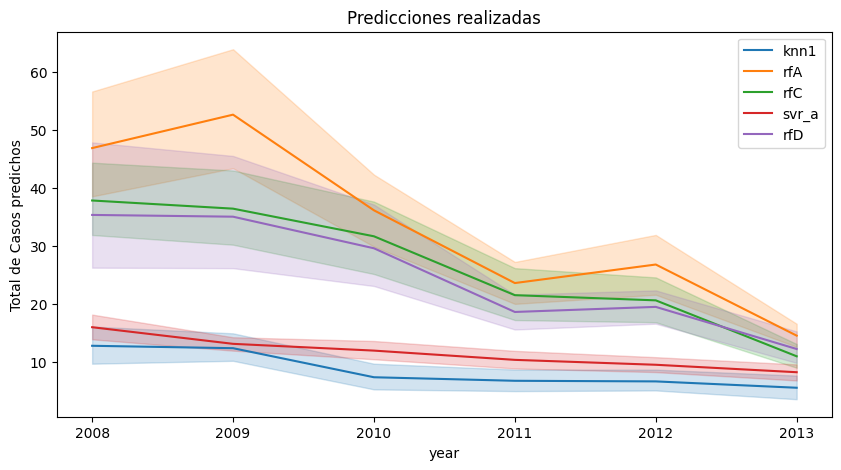

In [127]:
predicciones_df = resultados_df[['knn1','rfA','rfC','svr_a','rfD']]

plt.figure(figsize=(10,5))
ax = plt.subplot()

for pred in predicciones_df:
    sns.lineplot(data=resultados_df, x='year', y=pred, label=pred).set_title("Predicciones realizadas")
ax.set_ylabel("Total de Casos predichos")


Nuestra mejor predicción se encuentra de verde. (Random Forest C: PCA + 1week)

Con una tendencia simiar esta nuestra última entrada: (Random Fores D: 2week)

Sin embargo la diferencia en el Score es mucho más signifitiva de lo que nos sugeriría la gráfica.

<br>

Vamos a analizar estas dos predicciónes a mayor detalle

In [208]:
resultados_rfCD =test[['city','year','week_start_date']].copy()

resultados_rfCD['rfD'] = rfD_submission['total_cases']
resultados_rfCD['rfC'] = randomForest_PCA_1week['total_cases']

resultados_sj = resultados_rfCD[resultados_rfCD['city'] == 'sj']
resultados_iq = resultados_rfCD[resultados_rfCD['city'] == 'iq']


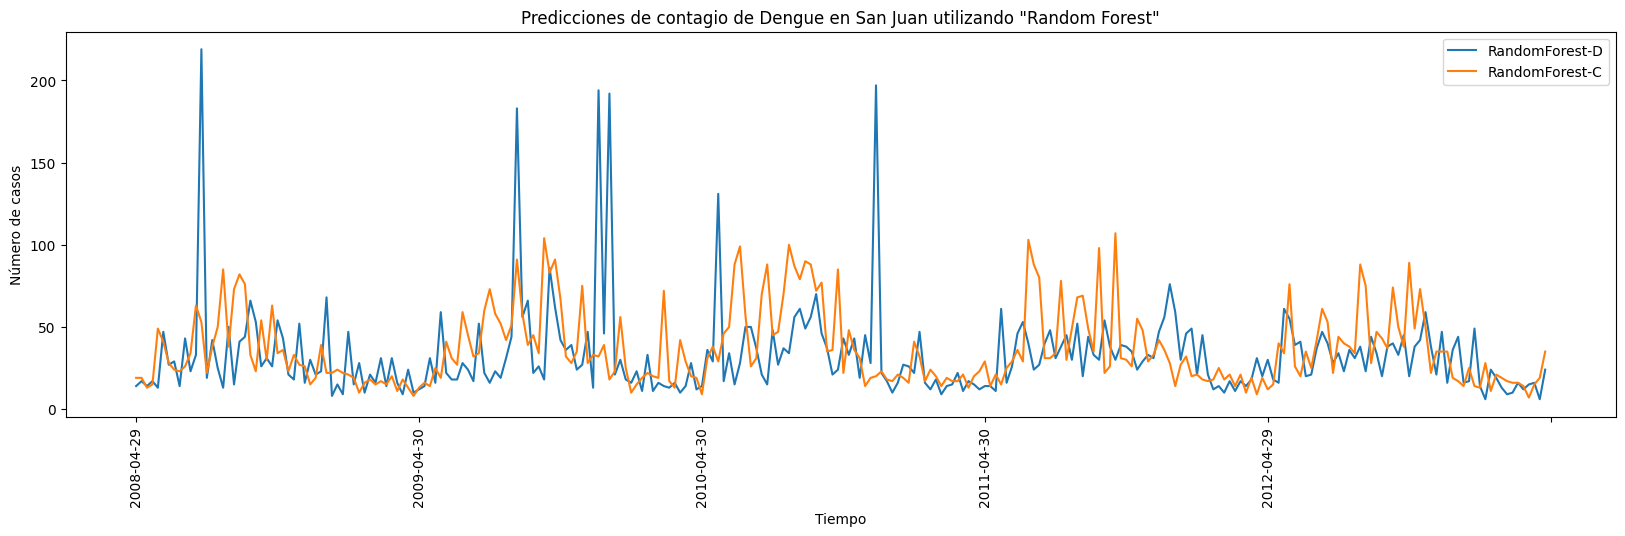

In [213]:
plt.figure(figsize=(20,5))
plt.xticks(rotation=90,ticks=[0,52,104,156,208,260])
ax = plt.subplot()
sns.lineplot(data = resultados_sj, x = 'week_start_date', y = 'rfD', ax = ax, estimator = None)
sns.lineplot(data = resultados_sj, x = 'week_start_date', y = 'rfC', ax = ax, estimator = None)
ax.set_title('Predicciones de contagio de Dengue en San Juan utilizando "Random Forest"')
ax.set_ylabel('Número de casos')
ax.set_xlabel('Tiempo')
ax.legend(['RandomForest-D', 'RandomForest-C'])

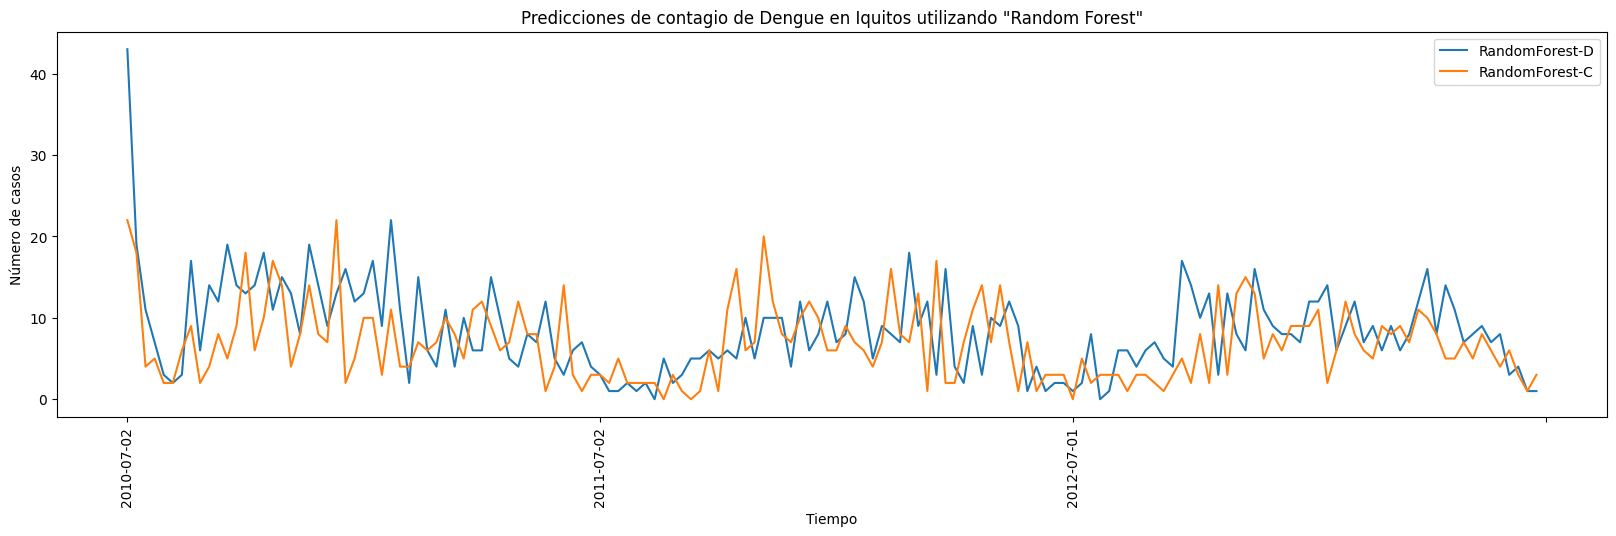

In [214]:
plt.figure(figsize=(20,5))
plt.xticks(rotation=90,ticks=[0,52,104,156,208,260])
ax = plt.subplot()
sns.lineplot(data = resultados_iq, x = 'week_start_date', y = 'rfD', ax = ax, estimator = None)
sns.lineplot(data = resultados_iq, x = 'week_start_date', y = 'rfC', ax = ax, estimator = None)
ax.set_title('Predicciones de contagio de Dengue en Iquitos utilizando "Random Forest"')
ax.set_ylabel('Número de casos')
ax.set_xlabel('Tiempo')
ax.legend(['RandomForest-D', 'RandomForest-C',])

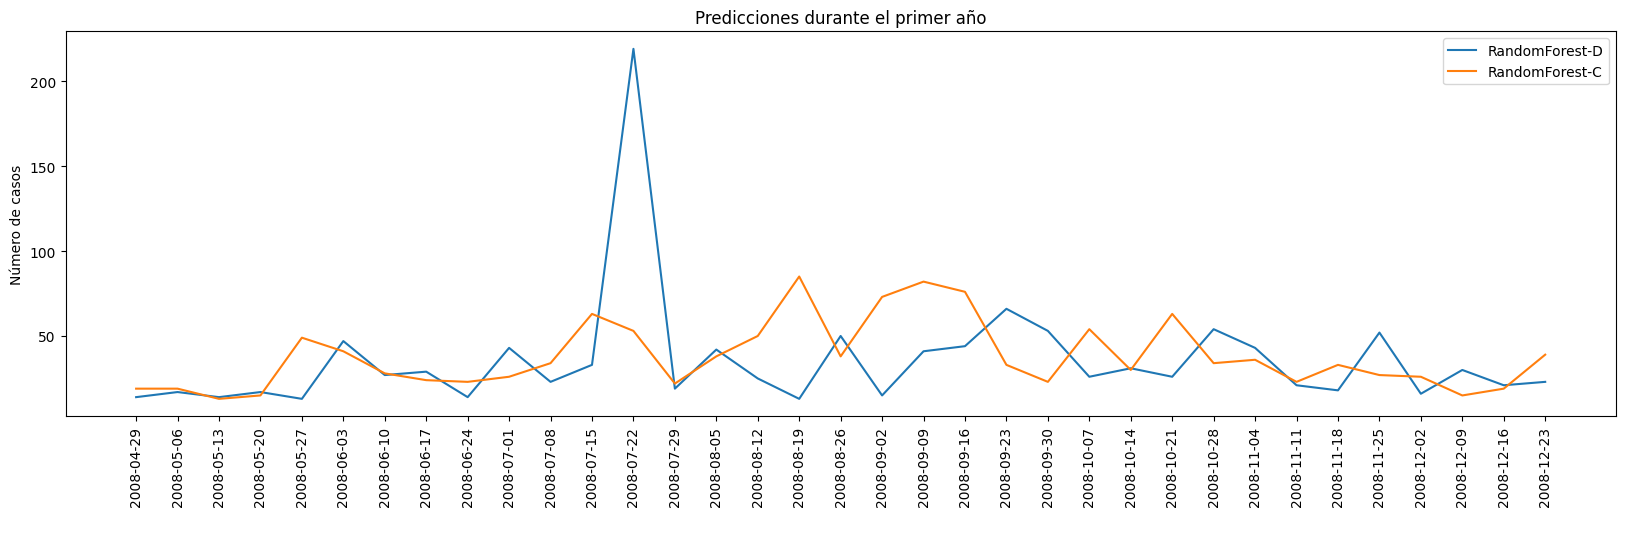

In [217]:
resultados_2years = resultados_rfCD[(resultados_rfCD['year'] == 2008) ]

resultados_2years_sj = resultados_2years[resultados_2years['city'] == 'sj']
resultados_2years_iq = resultados_2years[resultados_2years['city'] == 'iq']

plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
ax = plt.subplot()
sns.lineplot(data = resultados_2years_sj, x = 'week_start_date', y = 'rfD', ax = ax, estimator=None)
sns.lineplot(data = resultados_2years_sj, x = 'week_start_date', y = 'rfC', ax = ax, estimator=None)
ax.set_title('Predicciones durante el primer año San Juan')
ax.set_ylabel('Número de casos')
ax.set_xlabel(' ')
ax.legend(['RandomForest-D', 'RandomForest-C'])

RandomForest-D se muestra con valores más "extremos" ademas parece que no esta correctamente alineado, haremos un intento de alineación.

La línea azul en nuestra gráfica representa la predicción RandomForest-D en la cual observamos picos de casos más elevados. Posiblemente se deba a que no realizamos agrupación de variables mediante PCA como en el primer caso.

<br>

Una hipótesis es que los buenos resultados de RandomForestC se deben al uso de las PCA agrupadas

<br>

Hay todavía mucho margen por explorar y mejorar, hasta ahora la mejora en los resultados ha venido de un análisis y tratamiento previo de los datos. Considero que exploraciones futuras se deben centrar tanto en explorar más profundamente los datos como en el mejoramiento de los hiperparámetros.

<br>

Hasta aquí he analizado las predicciones enviadas a la competición, DengAI, no tenemos acceso a las respuestas, pero visualizaremos que tal estuvieron las predicción de nuestro mejor modelo con respercto al set de entrnamiento.



In [188]:
"""
   Volvemos a repetir el código de Random Forest C -> PCA + 1week
"""
# Dividimos en train test el dataset
X = train_PCA.iloc[:, :-1]
y = train_PCA.iloc[:, -1]

# Volvemos al modelo de Random Forest A con un nuevo dataset.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 28,
                                  max_depth=25,
                                  min_samples_split = 3,
                                  n_jobs = -1,
                                  random_state = seed)
regressor.fit(X_train, y_train)

predict_training_df = regressor.predict(X) # Predecimos todo el dataset de entrenamiento


In [192]:
# Hay dos valores faltantes, de la primera semana de San Juan y de Iquitos.
# no los puedo calcular porq no tengo los datos de la semana anterior a la captura de datos.
predict_training_df.shape

(1454,)

In [193]:
# Generacion del Dataset para el Score RandomForest-C
og_train = train[['city','year','week_start_date','total_cases']].copy()

# falta adelantar dos datos faltantes, uno por San Juan, otro por Iquitos.
# lo mismo, eliminar la primera semana de San Juan, y la primera de Iquitos.


# Elimino la primera semana de San Juan
og_train = og_train.iloc[1:]
og_train = og_train.reset_index(drop=True)

# Encuentro la primera semana de Iquitos
index = (og_train['city'] == 'iq').idxmax()
og_train = og_train.drop(index)
og_train = og_train.reset_index(drop=True)

og_train['total_predicted'] = predict_training_df.astype(int)

og_train.head()


,city,year,week_start_date,total_cases,total_predicted
0,sj,1990,1990-05-07,5,12
1,sj,1990,1990-05-14,4,13
2,sj,1990,1990-05-21,3,9
3,sj,1990,1990-05-28,6,10
4,sj,1990,1990-06-04,2,71


In [195]:
# Para graficar adecuadamente dividire el dataset para cada Ciudad

predict_sj = og_train[og_train['city'] == 'sj']
predict_iq = og_train[og_train['city'] == 'iq']


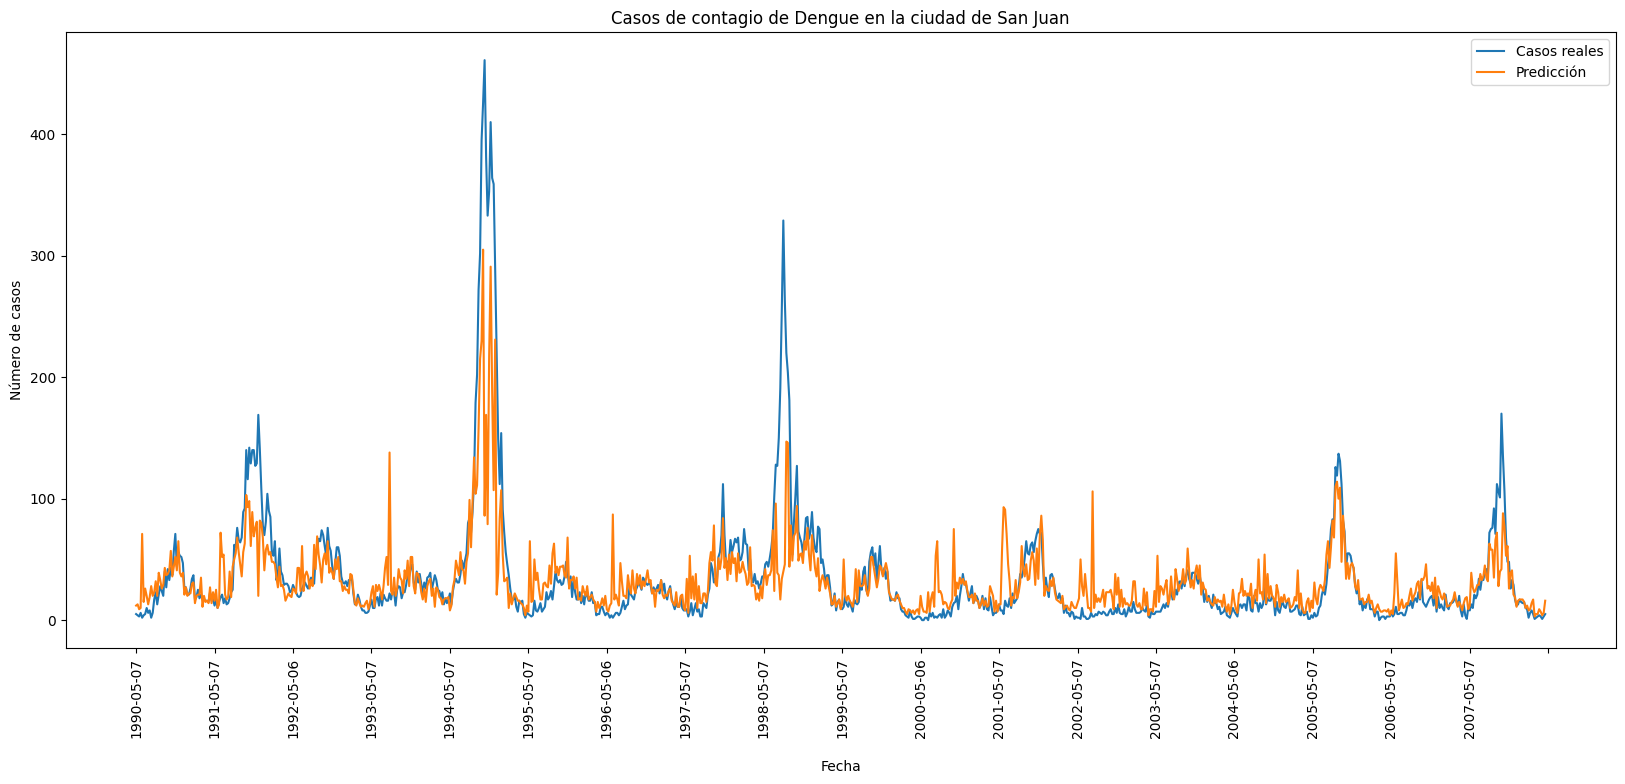

In [206]:
# pequeña funcion para calcular xticks cada año (52 semanas)
def generate_array(num_elements):
  return [i * 52 for i in range(num_elements)]

plt.figure(figsize=(20,8))
plt.xticks(rotation=90,ticks=generate_array(21))

ax = plt.subplot()

sns.lineplot(data = predict_sj, x = 'week_start_date', y = 'total_cases', ax = ax,  estimator=None)
sns.lineplot(data = predict_sj, x = 'week_start_date', y = 'total_predicted', ax = ax,  estimator=None)
ax.set_title('Casos de contagio de Dengue en la ciudad de San Juan')
ax.set_ylabel('Número de casos')
ax.set_xlabel('\nFecha')
ax.legend(['Casos reales','Predicción'])

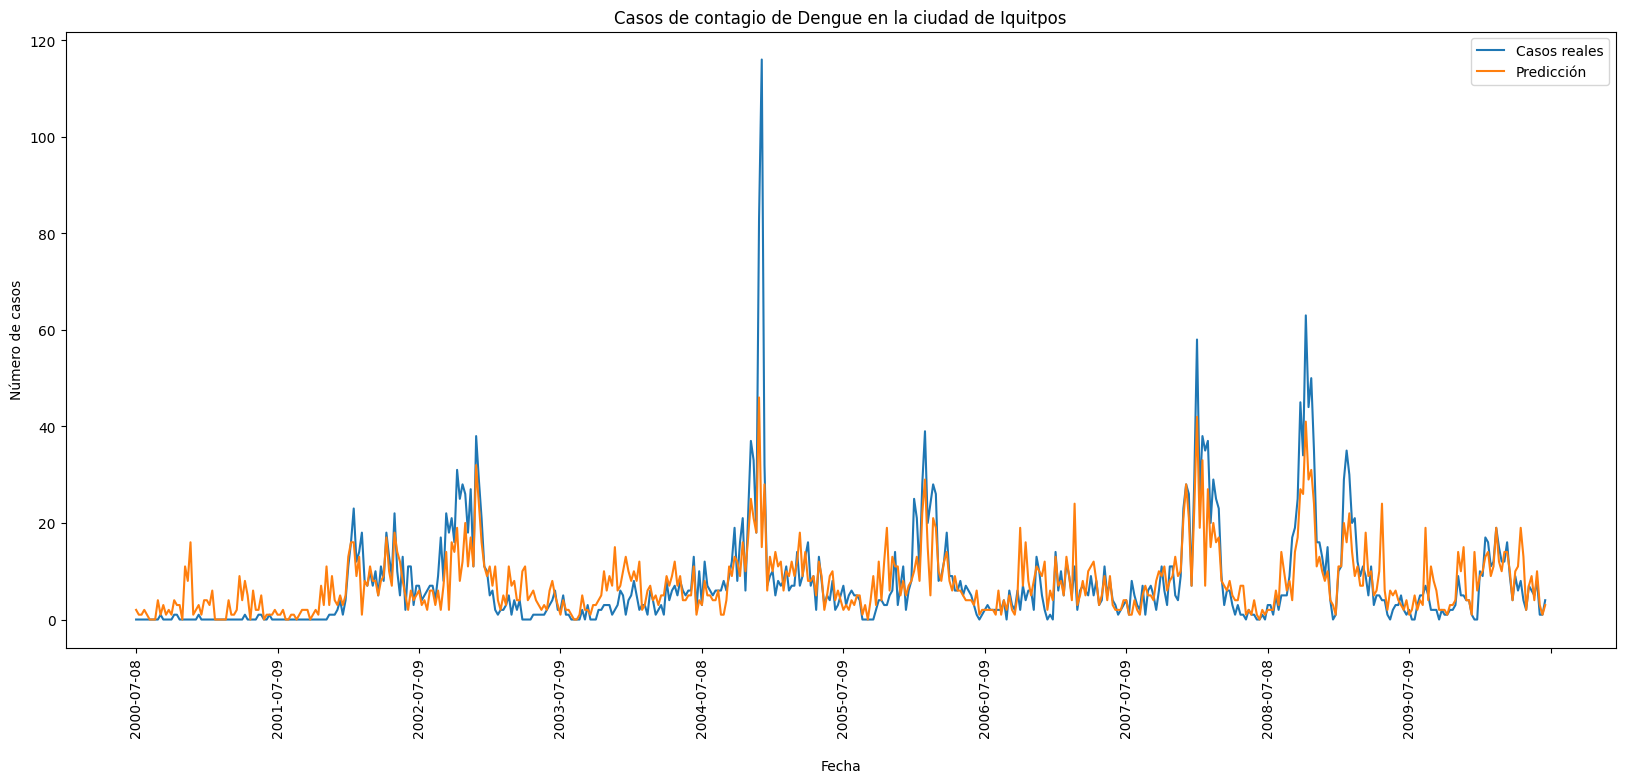

In [207]:
plt.figure(figsize=(20,8))
plt.xticks(rotation=90,ticks=generate_array(11))

ax = plt.subplot()

sns.lineplot(data = predict_iq, x = 'week_start_date', y = 'total_cases', ax = ax,  estimator=None)
sns.lineplot(data = predict_iq, x = 'week_start_date', y = 'total_predicted', ax = ax,  estimator=None)
ax.set_title('Casos de contagio de Dengue en la ciudad de Iquitpos')
ax.set_ylabel('Número de casos')
ax.set_xlabel('\nFecha')
ax.legend(['Casos reales','Predicción'])

Visualmente tenemos un ajusta acepatable en ambos casos, esto es de esperarse dado que utilizamos este dataset para el entrenamiento.


---
# Conclusiones
---

| Modelo | MAE test (DrivenData) | MAE validación | Algoritmo | Hiperparámetros | Descripción
| --- | --- | --- | --- | --- | --- |
| **RandomForest C** | **26,8798** | 23,5787 | RandomForest | árboles=28; prof=25; min_hojas=3 | Random Forest, PCA por grupos 1 semana "atrás"
| RandomForest C | 27,3534 | 23,5787 | RandomForest | árboles=28; prof=25; min_hojas=3 | Random Forest, PCA por grupos "misma semana"
| RandomForest A | 28,7500 | 18,1234 | RandomForest | árbles=25; prof=ninguna;  | Random Forest, cuatro 'features'
| KNN-1 | 30,3558 | 18,1234 | KNN | hp1='uniform'; vacinos=19 | kNN inicial, cuatro 'features' dos modelos uno para cada ciudad
| SVR_A | 29,6346 | 17,1323 | SVR | 'C': 100, 'eps': 0.3, 'gam': 'auto', 'kern': 'rbf' | promete pero en mi opinion esta sobre ajustado.
| RandomForest D | 29.9159 | 19.5476 | RandomForest | 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 18 | Demasiada varianza en la predicción
| ...


**Modelo final elegido**
* Nombre/Identificador: **`Random Forest C`** (1 semana atrás)
* MAE test (DrivenData): **`26.8798`**
* MAE validación: **`23.5787`**
* Algoritmo ML: **`Random Forest`**
* Hiperparámetros: **`n_estimators = 28; max_depth = 25; min_samples_split = 3`**
* Lista de características: **`RandomForestRegressor; train_test_split = 0.2`**
* Resumen del dataset (transformaciones aplicadas, etc.):
   - Se retrasa la variable objetivo en una semana
   - Se agrupa las variables con correlación media usando PCA, manteniendo las variables de mayor correlación.
   - Se realiza una busqueda manual de hiperparámetros.

**Acerca del dataset**

- Hay una clara influencia del _tiempo_ en el dataset,
   
   Esto se evidencio tanto en la elección final del dataset (retrasar una semana la variable objetivo) como en la correlación existente en la ciudad de San Juan entre la variable `'weekofyear'` es posible que para San Juan exista estacionalidad, talves esta no sea anual, sino cada 9 meses, esto queda pendiente explorar.

- Es más importante la calidad de los datos que el algoritmo.

   Si bien hubo una mejora al cambiar de algoritmo (KNN ➡ RandomForest) esta no fue tan significativa como trabajar para mejorar el dataset. Un buen dataset mejorará significativamente casi todos los algoritmos.


- Con un buen dataset es posible la mejora de Hiperparámetros.

   El impacto de un buen dataset no solo influye en el resultado obtenido, sino que también observamos una mejora más significativa a la hora de tunear los hiperparámetros

- La intuición no siempre es acertada.
   
   En la Actividad 1 descarte algunas variables al compararlas entre ellas, sin embargo, cuando tenemos la variables objetivo la correlación puede cambiar completamente. Si bien no resultó beneficioso variables altamente correlacionadas entre sí, si saltaron a la luz algunas variables que no parecian ser muy útiles al analizarlas aisladas de nuestro objetivo.

<br>

**Mejoras Futuras**

- Dos ciudades, dos modelos.

   Considero que las diferencias existentes entre ambas ciudades pueden ser aprovechadas para exprimir algo más de precisión. Posiblemente llegando a implementar algoritmos diferentes para cada ciudad.

- Evolución en el tiempo.

   Especialmente para San Juan, hay evidencias de que un modelo basado en series temporales puede ser efectivo.

   En nuestro análisis se volvió atrás una semana todas las variables, talves esto no fue lo más indicado para todas las variables, posiblemente algunas deban mantenerse en la misma semana. Especialmente porq se evidenció que el mayor impacto es producido en el trabajo sobre el dataset.

   Además el dataset `test` nos solicita realizar predicciones desde el 2008 al 2013. Volviendo a la actividad 1, sabemos que alrededor del año 2000 las mediciones de varias variables difieren considerablemente, ¿Sera que las medidas más antiguas en San Juan son contraproducentes?

- Random Forest es el mejor algoritmo de los probados, pero sería interesate explorar XGBoost.

- Redes Neuronales.

   Hasta el momento no fue posible utilizar técnicas que aprovechen las redes neuronales, sería interesante explorar esta posibilidad.


---
# Competición
---

Adjunto la captura de las entregas hasta la de mejor puntaje. Luego hubieron más intentos, con un usuario diferente para saltar el límite de los tres por día, sin emabargo no logré el objetivo de mejorar el modelo, incluyo la captura al final
```
usuario:  epalaciosm
```



![picture](https://drive.google.com/uc?id=16S_eZsx-rX5lbU8AoGygCroPmzwWFW06)

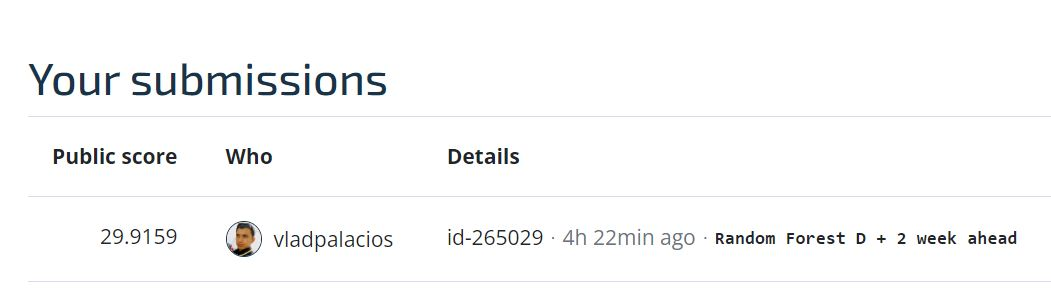